In [1]:
# import tensorflow as tf
# from tensorflow.keras import datasets, layers, models

# # Detect and initialize the TPU
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#     tpu_dict = tpu.cluster_spec().as_dict()
#     print('Cluster spec keys:', tpu_dict.keys())
#     if 'worker' in tpu_dict:
#         print('Running on TPU ', tpu_dict['worker'])
#     else:
#         print('No TPU worker found. Cluster spec:', tpu_dict)
# except ValueError:
#     raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [3]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense, LSTM
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)
from matplotlib.pyplot import specgram
import glob
import IPython.display as ipd  # To play sound in the notebook
import pickle
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-07-10 14:44:14.299687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 14:44:14.299791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 14:44:14.433859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
EMO = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"
# Run one example
dir_list = os.listdir(EMO)
dir_list[0:5]

['15a04Fd.wav', '13b02Fb.wav', '09b01Wb.wav', '15a01Wa.wav', '14a05Wa.wav']

In [5]:

# Get the data location for EMO
dir_list = os.listdir(EMO)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if  (i[-6:-5]=='W') or (i[-6:-5]=='E') :
        emotion.append('Angry')
    elif i[-6:-5]=='F':
        emotion.append('Happy')
    elif (i[-6:-5]=='L') or (i[-6:-5]=='T'):
        emotion.append('Sad')
    elif i[-6:-5]=='A':
        emotion.append('Fear')
    elif i[-6:-5]=='N':
        emotion.append('Neutral')
    else:
        emotion.append('Unknown')
    path.append(EMO + i)

# Now check out the label count distribution
EMO_df = pd.DataFrame(emotion, columns = ['emotion'])
EMO_df['source'] = 'EMO'
EMO_df = pd.concat([EMO_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
EMO_df.emotion.value_counts()


emotion
Angry      173
Sad        143
Neutral     79
Happy       71
Fear        69
Name: count, dtype: int64

In [6]:
# Get the data location for EMO
dir_list = os.listdir(EMO)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if  (i[-6:-5]=='W') :
        emotion.append('Angry')
    elif (i[-6:-5]=='E') :
        emotion.append('Disgust')
    elif i[-6:-5]=='F':
        emotion.append('Happy')
    elif (i[-6:-5]=='L') :
        emotion.append('Boredom')
    elif (i[-6:-5]=='T') :
        emotion.append('Sadness')
    elif i[-6:-5]=='A':
        emotion.append('Fear')
    elif i[-6:-5]=='N':
        emotion.append('Neutral')
    else:
        emotion.append('Unknown')
    path.append(EMO + i)

# Now check out the label count distribution
EMO_df = pd.DataFrame(emotion, columns = ['emotion'])
EMO_df['source'] = 'EMO'
EMO_df = pd.concat([EMO_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
EMO_df.emotion.value_counts()


emotion
Angry      127
Boredom     81
Neutral     79
Happy       71
Fear        69
Sadness     62
Disgust     46
Name: count, dtype: int64

In [7]:
df = pd.concat([EMO_df], axis = 0)
print(df.emotion.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

emotion
Angry      127
Boredom     81
Neutral     79
Happy       71
Fear        69
Sadness     62
Disgust     46
Name: count, dtype: int64


In [8]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head(10)

emotion source                                               path
0    Happy    EMO  /kaggle/input/berlin-database-of-emotional-spe...
1    Happy    EMO  /kaggle/input/berlin-database-of-emotional-spe...
2    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...
3    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...
4    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...
5     Fear    EMO  /kaggle/input/berlin-database-of-emotional-spe...
6    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...
7  Sadness    EMO  /kaggle/input/berlin-database-of-emotional-spe...
8    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...
9    Angry    EMO  /kaggle/input/berlin-database-of-emotional-spe...

In [9]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', None)
df.sample(100)

emotion source  \
458  Neutral    EMO   
235    Angry    EMO   
281     Fear    EMO   
55      Fear    EMO   
284  Boredom    EMO   
..       ...    ...   
60   Disgust    EMO   
452    Happy    EMO   
204  Sadness    EMO   
371    Happy    EMO   
164  Disgust    EMO   

                                                                        path  
458  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12b02Na.wav  
235  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15b02Wc.wav  
281  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/16b10Aa.wav  
55   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13a05Aa.wav  
284  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03b02La.wav  
..                                                                       ...  
60   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11b01Eb.wav  
452  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b09Fb.wav  
204  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11b09Td.wav  
371  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a05Fc.wav  
164  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14b01Eb.wav  

[100 rows x 3 columns]

<Axes: ylabel='count'>

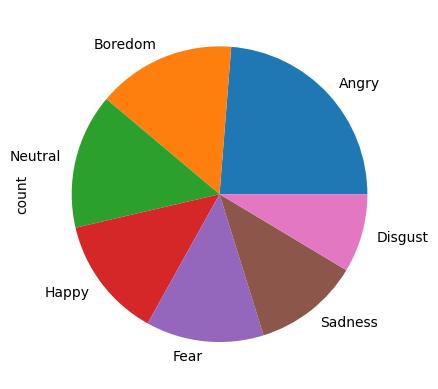

In [10]:
# LOOK AT DISTRIBUTION OF CLASSES
df.emotion.value_counts().plot(kind='pie')

In [11]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.6 MB/s eta 0:00:00


In [12]:
import resampy
from resampy import resample
import librosa

In [13]:
# for index, path in enumerate(ref.path):
#     print(path)
#     X, sample_rate = librosa.load(path
#                                   ,res_type='kaiser_fast'
#                                   ,duration=3
#                                   ,sr=44100
#                                   ,offset=0.5
#                                  )
#     break

In [14]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['Features'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    result = np.array([])

    # mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                        sr=sample_rate,
                                        n_mfcc=20),
                    axis=0)
    result=np.hstack((result, mfccs)) # stacking horizontally

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    result=np.hstack((result, log_spectrogram)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(X))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    df.loc[counter] = [result]
    counter=counter+1


# Check a few records to make sure its processed successfully
print(len(df))
df.head()

535


Features
0                                     [-6.198480129241943, -6.05307149887085, -8.172293663024902, -9.85007095336914, -11.289501190185547, -8.838212013244629, -9.453510284423828, -11.055927276611328, -12.054287910461426, -9.222416877746582, -8.164298057556152, -7.286595344543457, -5.771480560302734, -4.705183506011963, -6.778958320617676, -7.623713493347168, -10.559484481811523, -11.928592681884766, -8.509498596191406, -8.139226913452148, -11.996193885803223, -14.334912300109863, -13.096972465515137, -7.832364559173584, -6.734525203704834, -9.74810791015625, -13.636817932128906, -13.25019359588623, -11.877840995788574, -11.961441040039062, -11.411230087280273, -11.394837379455566, -13.826536178588867, -13.256582260131836, -13.376286506652832, -10.464762687683105, -10.457712173461914, -12.9341402053833, -14.343862533569336, -14.65925121307373, -14.00798225402832, -13.3446044921875, -11.877531051635742, -11.646367073059082, -11.677350044250488, -11.33321762084961, -13.48454475402832, -14.41350269317627, -14.44421100616455, -15.706298828125, -15.195793151855469, -15.469813346862793, -16.16606330871582, -15.603938102722168, -16.930835723876953, -15.316909790039062, -14.598548889160156, -14.663839340209961, -15.434316635131836, -16.76766586303711, -16.24168586730957, -16.79726791381836, -16.585464477539062, -15.1277494430542, -15.399324417114258, -15.718902587890625, -15.182833671569824, -14.189462661743164, -15.226061820983887, -15.75871753692627, -16.373332977294922, -15.465182304382324, -17.318235397338867, -18.41497802734375, -16.073823928833008, -15.883891105651855, -15.739614486694336, -13.335177421569824, -10.655750274658203, -8.811296463012695, -8.984041213989258, -8.333552360534668, -7.254678249359131, -7.053553104400635, -6.226914882659912, -5.936802387237549, -5.9937639236450195, -5.803048133850098, -6.003204345703125, -5.905764102935791, -6.026132106781006, -5.844988822937012, -5.692324638366699, -6.617223262786865, -7.771332740783691, -7.293577671051025, -7.163280487060547, -8.20622444152832, -9.015265464782715, -10.138566970825195, ...]
1                            [-19.341650009155273, -17.059608459472656, -10.889122009277344, -5.511610984802246, -3.368029832839966, -4.456704616546631, -6.262477397918701, -7.763258457183838, -7.757613182067871, -7.2550835609436035, -7.711968898773193, -7.545346260070801, -7.402634620666504, -7.178396701812744, -8.038668632507324, -7.810484409332275, -6.4350104331970215, -6.115895748138428, -7.689072608947754, -8.78446102142334, -9.852506637573242, -10.407403945922852, -10.391016006469727, -10.363593101501465, -9.271235466003418, -9.92216968536377, -11.471489906311035, -12.775435447692871, -13.509074211120605, -14.600271224975586, -16.200029373168945, -15.76655101776123, -15.23173713684082, -11.81700325012207, -9.349642753601074, -11.212685585021973, -10.704298973083496, -12.4421968460083, -15.815096855163574, -9.990373611450195, -8.575718879699707, -7.459824562072754, -8.392743110656738, -12.347356796264648, -9.746912002563477, -10.62134838104248, -17.30875015258789, -19.003093719482422, -17.692245483398438, -8.64794921875, -3.9130547046661377, -3.441896915435791, -4.293300151824951, -6.376184463500977, -7.101601600646973, -5.622299671173096, -6.686112880706787, -9.608602523803711, -15.71668529510498, -15.182050704956055, -15.260965347290039, -15.877392768859863, -16.759517669677734, -16.371728897094727, -15.228805541992188, -15.709718704223633, -16.57597541809082, -16.261157989501953, -16.22391128540039, -15.321538925170898, -14.228464126586914, -16.834089279174805, -14.172904968261719, -12.360547065734863, -15.454294204711914, -17.879405975341797, -16.697101593017578, -15.583061218261719, -15.653196334838867, -15.798851013183594, -15.04930305480957, -14.991114616394043, -13.922643661499023, -12.808688163757324, -13.2529878616333, -15.080304145812988, -17.75888442993164, -15.642969131469727, -15.003636360168457, -13.051942825317383, -11.880941390991211, -13.001172065734863, 

In [15]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['Features'].values.tolist())],axis=1)
df[:5]

emotion source  \
0   Happy    EMO   
1   Happy    EMO   
2   Angry    EMO   
3   Angry    EMO   
4   Angry    EMO   

                                                                      path  \
0  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav   
1  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav   
2  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav   
3  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav   
4  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav   

           0          1          2          3          4          5  \
0  -6.198480  -6.053071  -8.172294  -9.850071 -11.289501  -8.838212   
1 -19.341650 -17.059608 -10.889122  -5.511611  -3.368030  -4.456705   
2  -7.836340 -10.748720 -13.002162 -15.769855 -19.792629 -20.879389   
3  -9.661450 -13.410833 -21.398672 -18.266544 -19.377432 -20.011532   
4  -2.109087  -5.171371 -19.110546 -17.919163 -17.988585 -17.408344   

           6  ...       521       522       523       524       525       526  \
0  -9.453510  ...       NaN       NaN       NaN       NaN       NaN       NaN   
1  -6.262477  ...       NaN       NaN       NaN       NaN       NaN       NaN   
2 -17.127483  ...       NaN       NaN       NaN       NaN       NaN       NaN   
3 -20.138466  ...       NaN       NaN       NaN       NaN       NaN       NaN   
4 -17.192352  ...  0.522531  0.569145  0.610384  0.612827  0.593237  0.562371   

        527      528       529       530  
0       NaN      NaN       NaN       NaN  
1       NaN      NaN       NaN       NaN  
2       NaN      NaN       NaN       NaN  
3       NaN      NaN       NaN       NaN  
4  0.518055  0.52004  0.586579  0.098722  

[5 rows x 534 columns]

In [16]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(535, 534)


emotion source  \
0   Happy    EMO   
1   Happy    EMO   
2   Angry    EMO   
3   Angry    EMO   
4   Angry    EMO   

                                                                      path  \
0  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav   
1  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav   
2  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav   
3  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav   
4  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav   

           0          1          2          3          4          5  \
0  -6.198480  -6.053071  -8.172294  -9.850071 -11.289501  -8.838212   
1 -19.341650 -17.059608 -10.889122  -5.511611  -3.368030  -4.456705   
2  -7.836340 -10.748720 -13.002162 -15.769855 -19.792629 -20.879389   
3  -9.661450 -13.410833 -21.398672 -18.266544 -19.377432 -20.011532   
4  -2.109087  -5.171371 -19.110546 -17.919163 -17.988585 -17.408344   

           6  ...       521       522       523       524       525       526  \
0  -9.453510  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  -6.262477  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2 -17.127483  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3 -20.138466  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4 -17.192352  ...  0.522531  0.569145  0.610384  0.612827  0.593237  0.562371   

        527      528       529       530  
0  0.000000  0.00000  0.000000  0.000000  
1  0.000000  0.00000  0.000000  0.000000  
2  0.000000  0.00000  0.000000  0.000000  
3  0.000000  0.00000  0.000000  0.000000  
4  0.518055  0.52004  0.586579  0.098722  

[5 rows x 534 columns]

In [17]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','emotion','source'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

0          1          2          3          4          5    \
441  -7.596025  -8.363722  -7.523763  -6.790006  -1.606237   1.290279   
321 -18.748207 -15.615764 -15.878392 -16.362751 -14.500582 -13.131189   
417  -5.823838  -3.688892  -2.897330  -4.129182  -7.406299  -9.312857   
297  -5.647016  -8.838470 -13.719035 -14.251988 -12.096936 -11.802528   
36   -8.302549 -11.071767 -22.804571 -24.200247 -23.991392 -23.211870   
139 -10.996151 -14.433871 -22.793072 -21.793619 -22.111942 -23.436028   
253  -1.540946   0.648517   1.280165   1.043818   1.620793   1.418480   
519  -9.940400 -12.384032 -16.693214 -18.325687 -18.368267 -17.299597   
59   -2.333831  -2.648192  -4.579837  -4.879751  -4.105637  -3.073356   
111  -7.004236  -9.338232 -14.440801 -15.455816 -15.296768 -15.596484   

           6          7          8          9    ...       521       522  \
441   0.690439   0.788510  -0.100544  -1.949334  ...  0.000000  0.000000   
321 -12.793855 -11.636606 -11.995538 -15.995898  ...  0.000000  0.000000   
417  -8.317774  -9.121778 -11.347143 -13.904757  ...  0.566699  0.620935   
297 -11.010278 -11.443542  -6.815954  -5.673173  ...  0.000000  0.000000   
36  -22.169764 -17.123213 -16.128475 -16.087580  ...  0.477548  0.448664   
139 -22.603638 -22.192579 -23.225348 -22.473597  ...  0.000000  0.000000   
253   1.924521   1.931306   1.835997   1.878839  ...  0.000000  0.000000   
519 -16.133236 -17.054121 -15.275419 -12.544258  ...  0.000000  0.000000   
59   -2.757999  -3.059701  -2.752472  -2.601999  ...  0.780151  0.743203   
111 -12.180449  -8.668582  -8.434381 -11.400097  ...  0.000000  0.000000   

          523       524       525       526       527       528       529  \
441  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
321  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
417  0.621034  0.542852  0.452712  0.420146  0.420926  0.495533  0.561221   
297  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
36   0.477793  0.577414  0.600446  0.435537  0.364280  0.387479  0.402770   
139  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
253  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
519  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
59   0.726622  0.760944  0.803105  0.821755  0.748613  0.674216  0.658936   
111  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          530  
441  0.000000  
321  0.000000  
417  0.164465  
297  0.000000  
36   0.071855  
139  0.000000  
253  0.000000  
519  0.000000  
59   0.051777  
111  0.000000  

[10 rows x 531 columns]

In [18]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
(428, 531, 1)
(107, 531, 1)


In [19]:
lb.classes_

array(['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral',
       'Sadness'], dtype=object)

In [20]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model.fit(X_train,y_train, batch_size=32, epochs=400, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 531, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 524, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 262, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 262, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 262, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 262, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 131, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 131, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 131, 128)       │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 65, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 65, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 16, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,958,727 (11.29 MB)

 Trainable params: 2,956,423 (11.28 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/400
 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2010 - loss: 6.5388

I0000 00:00:1720622798.052470      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720622798.082928      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1852 - loss: 6.4577  

W0000 00:00:1720622813.894925      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.16822, saving model to SER_best_initial_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1841 - loss: 6.4453 - val_accuracy: 0.1682 - val_loss: 4.5321
Epoch 2/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1851 - loss: 5.7892
Epoch 2: val_accuracy improved from 0.16822 to 0.21495, saving model to SER_best_initial_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1881 - loss: 5.7509 - val_accuracy: 0.2150 - val_loss: 4.7302
Epoch 3/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2727 - loss: 4.8262
Epoch 3: val_accuracy improved from 0.21495 to 0.37383, saving model to SER_best_initial_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2753 - loss: 4.8246 - val_accuracy: 0.3738 - val_loss: 4.0788
Epoch 4/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3298 - loss: 4.4755
Epoch 4: val_accuracy did not improve from 0.37383
14/14 ━━━━━━━━━━━━━━━━━━━━ 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5208 - loss: 2.8259 
Loss of the model is -  2.8186447620391846
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5208 - loss: 2.8259 
Accuracy of the model is -  52.336448431015015 %
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step

W0000 00:00:1720622961.622692      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


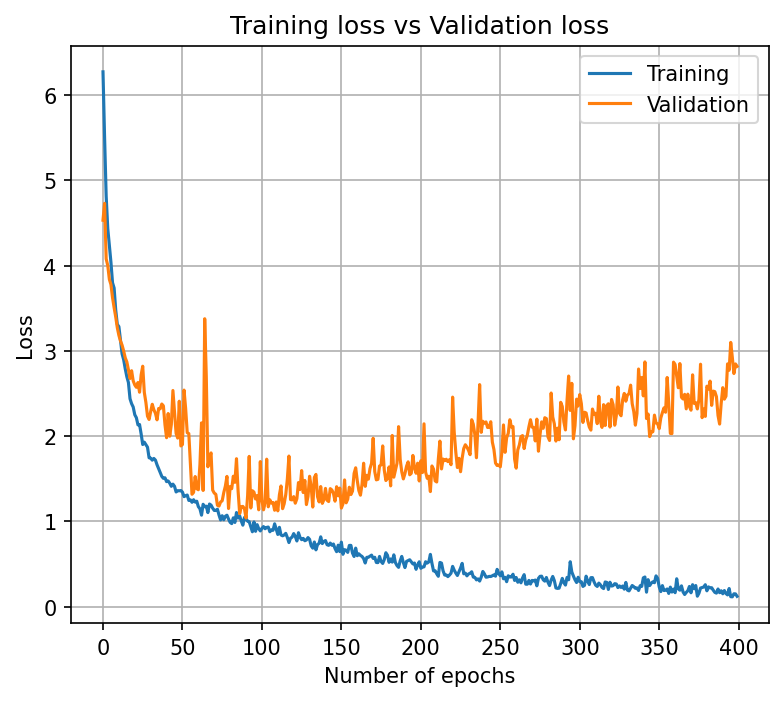

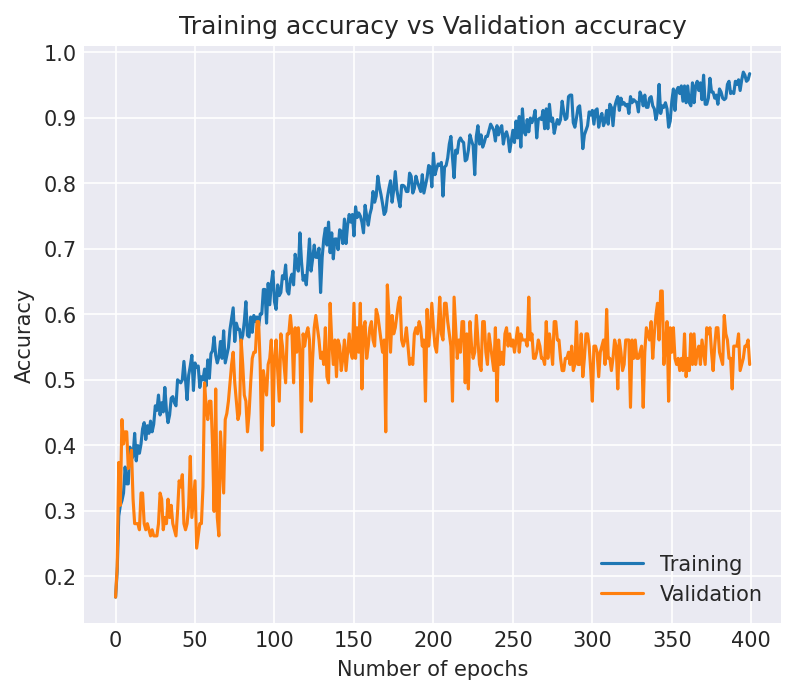

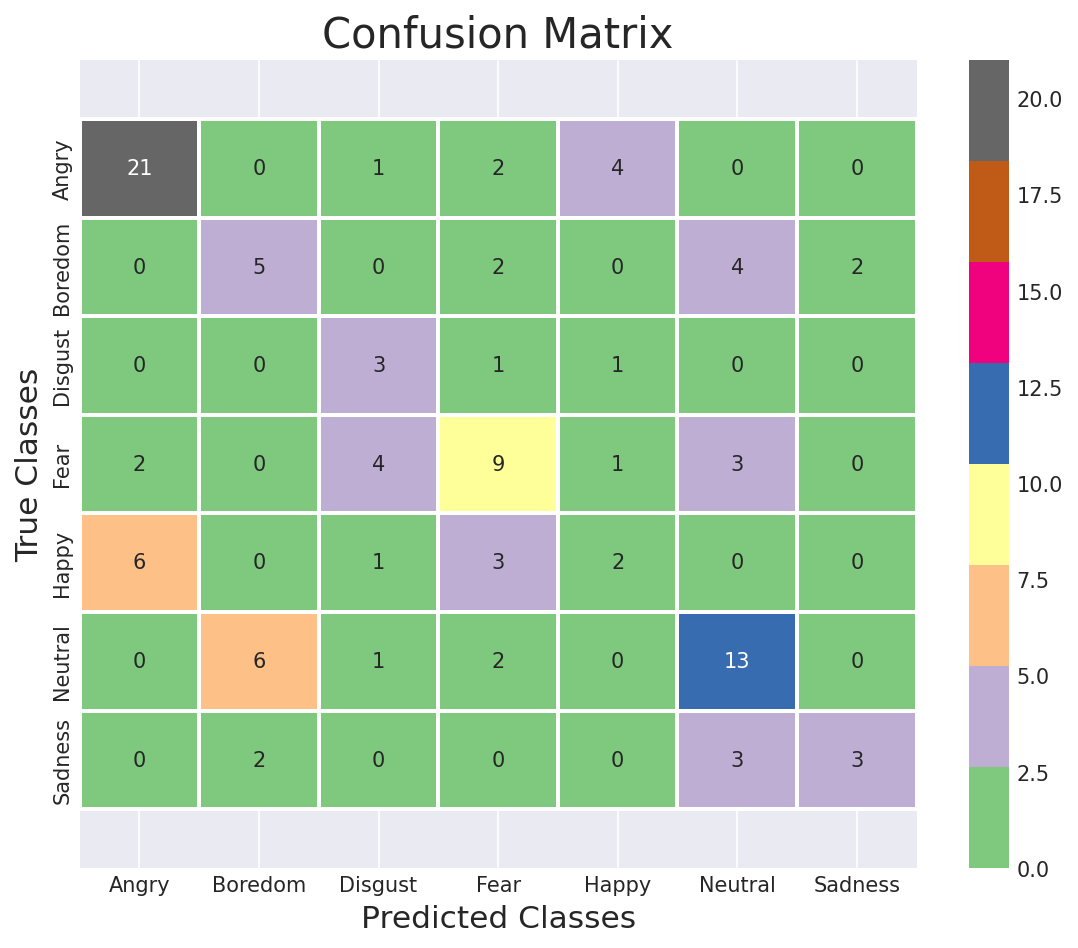

              precision    recall  f1-score   support

       Angry       0.72      0.75      0.74        28
     Boredom       0.38      0.38      0.38        13
     Disgust       0.30      0.60      0.40         5
        Fear       0.47      0.47      0.47        19
       Happy       0.25      0.17      0.20        12
     Neutral       0.57      0.59      0.58        22
         Sad       0.60      0.38      0.46         8

    accuracy                           0.52       107
   macro avg       0.47      0.48      0.46       107
weighted avg       0.52      0.52      0.52       107



In [21]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9, 7))
plt.rcParams['figure.dpi'] = 150
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()
print(classification_report(TRUE, predictions, target_names = ['Angry','Boredom','Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']))

In [22]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
import pandas as pd
df_mel = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)

    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)

    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)

    df_mel.loc[counter] = [log_spectrogram]
    counter=counter+1

print(len(df_mel))
df_mel.head()

535


mel_spectrogram
0                   [-17.007109, -13.130802, -12.605897, -14.705179, -18.622204, -22.5895, -25.834177, -28.27729, -33.187126, -17.958044, -11.6811, -10.758939, -10.572005, -11.07336, -10.946238, -10.37713, -9.289457, -8.529683, -9.454502, -13.961094, -23.96596, -27.677326, -26.51453, -15.854602, -12.125221, -14.411737, -17.53378, -18.36381, -19.614141, -19.626585, -18.772934, -17.995714, -18.094059, -16.918522, -14.217393, -11.913934, -11.291529, -11.912843, -11.403275, -10.966986, -11.40081, -13.912682, -15.783473, -16.848087, -17.484465, -16.07098, -14.321904, -13.701181, -14.235916, -14.561736, -13.7504225, -16.53504, -22.8953, -23.73153, -22.534613, -19.10683, -19.815002, -22.795351, -20.946674, -18.09242, -14.086685, -11.733979, -8.370209, -5.9620314, -6.7153907, -7.160418, -8.158543, -7.9309263, -9.169153, -9.984346, -9.58216, -8.404481, -8.069675, -8.92303, -9.164841, -9.546991, -11.379847, -17.591059, -26.336725, -23.285515, -21.54502, -21.307772, -20.379076, -19.532598, -19.249382, -19.082813, -19.375036, -21.652937, -23.836704, -24.802303, -26.225454, -27.980247, -30.002329, -32.514744, -34.740417, -35.70924, -37.479496, -38.206394, -39.598484, -41.23529, ...]
1  [-45.350304, -43.536835, -24.03202, -13.525582, -10.562477, -10.242782, -8.356424, -7.120185, -6.5443053, -4.73006, -5.497998, -6.7678957, -8.031258, -9.01384, -13.420309, -17.315187, -14.989897, -15.660908, -17.261837, -20.150198, -23.520723, -25.532808, -25.394316, -25.27865, -24.558283, -23.685202, -22.375135, -20.248644, -18.887913, -18.048386, -17.227657, -18.169094, -19.026297, -17.635933, -18.030264, -21.246716, -29.263657, -41.229977, -44.22014, -19.989773, -12.459826, -9.874222, -10.118309, -10.591185, -10.002225, -15.682306, -32.759304, -42.634983, -43.942326, -18.437683, -11.317616, -12.750217, -15.604674, -15.722983, -14.818287, -15.123971, -15.753644, -13.511036, -13.615226, -14.388939, -13.916019, -13.548968, -14.074971, -13.65529, -13.612852, -15.656027, -18.098318, -19.370724, -20.209398, -21.054691, -22.306566, -25.178762, -26.582428, -27.986399, -30.094564, -32.549515, -31.908232, -32.443657, -32.39382, -33.70293, -35.461067, -36.51924, -36.58522, -38.118317, -39.058285, -40.576412, -40.363552, -38.776962, -37.03499, -29.69167, -23.771284, -22.102962, -20.891533, -20.755852, -20.725698, -21.163546, -22.46223, -24.303545, -26.718105, -27.566978, ...]
2  [-5.8619833, -6.5602007, -11.994356, -19.594387, -27.73669, -30.780792, -28.029644, -23.743032, -20.102976, -19.02481, -20.515163, -22.142775, -22.305914, -19.232088, -18.008236, -21.367834, -34.22014, -43.060623, -46.726955, -49.39624, -34.66681, -22.647871, -19.133757, -16.895277, -16.506567, -17.005854, -18.20339, -19.74121, -20.560518, -16.010292, -19.155956, -32.274506, -40.651276, -38.12672, -29.071714, -25.766285, -27.30129, -29.52404, -28.359974, -28.127554, -27.926546, -24.214079, -18.764927, -15.875356, -18.13127, -21.562967, -22.567352, -19.617258, -16.166065, -17.046165, -11.91511, -6.9138193, -5.1396546, -3.6421504, -4.4671984, -8.765396, -12.180385, -14.746264, -17.546568, -20.220762, -19.01974, -16.340738, -13.113528, -11.161776, -11.254767, -17.2442, -25.854483, -27.706003, -23.46286, -17.789282, -14.783846, -15.146795, -12.082336, -8.497319, -9.848574, -17.205103, -21.311995, -12.803546, -10.3815775, -11.902397, -13.284399, -16.54411, -23.376707, -24.870584, -25.900755, -27.716486, -28.960094, -32.100727, -31.031933, -22.498428, -17.810818, -14.953322, -14.765631, -16.67868, -17.251522, -15.951704, -15.943197, -14.192371, -13.142804, -15.518439, ...]
3               [-19.166243, -18.649145, -19.869135, -16.129456, -16.928436, -19.182177, -21.093227, -29.09631, -39.660084, -43.63098, -48.164215, -50.281784, -29.43521, -16.816416, -11.703167, -10.933099, -11.256721, -13.995777, -15.510036, -16.900692, -16.616495, -13.584397, -16.382322, -24.801779, -28.586403, -34.092815, -48.073013, -46.67416, -28.540533, -20.196802, -18.539043, -19.248701, -18.448853, -16.6726

In [23]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df[:5]

emotion source  \
0   Happy    EMO   
1   Happy    EMO   
2   Angry    EMO   
3   Angry    EMO   
4   Angry    EMO   

                                                                      path  \
0  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav   
1  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav   
2  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav   
3  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav   
4  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav   

           0          1          2          3          4          5  \
0 -17.007109 -13.130802 -12.605897 -14.705179 -18.622204 -22.589500   
1 -45.350304 -43.536835 -24.032021 -13.525582 -10.562477 -10.242782   
2  -5.861983  -6.560201 -11.994356 -19.594387 -27.736691 -30.780792   
3 -19.166243 -18.649145 -19.869135 -16.129456 -16.928436 -19.182177   
4  -1.033794  -2.577032  -7.847128  -7.890929  -8.296486  -7.332873   

           6  ...        249        250        251        252        253  \
0 -25.834177  ...        NaN        NaN        NaN        NaN        NaN   
1  -8.356424  ... -43.885750 -44.324665 -44.532341 -44.436733 -44.961933   
2 -28.029644  ...        NaN        NaN        NaN        NaN        NaN   
3 -21.093227  ...        NaN        NaN        NaN        NaN        NaN   
4  -8.774447  ...  -4.101072  -3.626120  -7.470054 -17.843517 -31.154068   

         254        255       256        257       258  
0        NaN        NaN       NaN        NaN       NaN  
1        NaN        NaN       NaN        NaN       NaN  
2        NaN        NaN       NaN        NaN       NaN  
3        NaN        NaN       NaN        NaN       NaN  
4 -31.730368 -29.196899 -24.72385 -22.428482 -22.09622  

[5 rows x 262 columns]

In [24]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','emotion','source'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

0          1          2          3          4          5    \
441 -28.847841 -26.006592 -19.935873 -13.624494 -11.461211  -7.543690   
321 -47.087486 -32.043980 -25.290089 -24.668079 -26.650463 -28.454464   
417 -13.470877 -10.909913 -12.085046 -15.312870 -19.564459 -21.432325   
297  -1.626291  -3.113498  -9.141175  -9.388008 -10.107248 -11.631190   
36   -7.992248  -9.403134 -14.680274 -13.565886 -13.270103 -12.086889   
139 -18.188053 -19.480829 -21.601156 -18.968634 -14.736557 -13.867261   
253 -27.065195 -27.078472 -27.152552 -27.002907 -26.759094 -21.675337   
519 -13.181077 -11.602422 -12.635466 -14.787504 -16.403816 -15.909000   
59  -18.064732 -17.655624 -20.113159 -21.380108 -21.251703 -20.281134   
111 -13.410645 -15.038159 -20.927675 -27.011246 -28.605333 -30.299463   

           6          7          8          9    ...        249        250  \
441  -5.270624  -6.933064 -13.873641 -25.869114  ...        NaN        NaN   
321 -29.590176 -28.919865 -30.524700 -36.032925  ...        NaN        NaN   
417 -21.237984 -20.792582 -21.471647 -22.075684  ... -10.071116 -12.770399   
297 -14.414032 -16.486561 -16.115671 -19.001453  ... -40.698898 -40.684990   
36   -9.679083 -11.125884 -15.852287 -17.774477  ... -27.696934 -29.344437   
139 -15.829862 -19.046984 -20.541449 -24.272110  ...        NaN        NaN   
253 -14.921411 -12.372520 -10.624579  -7.920948  ...        NaN        NaN   
519 -14.437092 -11.465672  -7.580680  -5.984771  ...        NaN        NaN   
59  -19.185781 -19.162930 -19.177124 -19.904800  ... -46.682755 -46.893105   
111 -23.899357 -15.802004 -11.762016 -13.860377  ...        NaN        NaN   

           251        252        253        254        255        256  \
441        NaN        NaN        NaN        NaN        NaN        NaN   
321        NaN        NaN        NaN        NaN        NaN        NaN   
417 -15.366923 -18.889771 -25.593090 -29.742495 -23.325426 -23.170296   
297 -41.833241 -43.403542 -44.538712        NaN        NaN        NaN   
36  -31.724596 -32.692856 -33.921806 -35.311947 -36.963970 -37.907974   
139        NaN        NaN        NaN        NaN        NaN        NaN   
253        NaN        NaN        NaN        NaN        NaN        NaN   
519        NaN        NaN        NaN        NaN        NaN        NaN   
59  -46.526478 -45.106808 -43.873756 -43.796551 -44.428177 -45.481415   
111        NaN        NaN        NaN        NaN        NaN        NaN   

           257        258  
441        NaN        NaN  
321        NaN        NaN  
417 -25.194199 -17.690710  
297        NaN        NaN  
36  -36.289612 -31.593193  
139        NaN        NaN  
253        NaN        NaN  
519        NaN        NaN  
59  -47.065742 -47.421589  
111        NaN        NaN  

[10 rows x 259 columns]

In [25]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
(428, 259, 1)
(107, 259, 1)


In [26]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model.fit(X_train,y_train, batch_size=32, epochs=400, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 259, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 252, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 126, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 126, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 126, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 63, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 63, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 63, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 31, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 31, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 15, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 7, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,303,367 (8.79 MB)

 Trainable params: 2,301,063 (8.78 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1437 - loss: nan  
Epoch 1: val_accuracy improved from -inf to 0.12150, saving model to SER_best_initial_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1438 - loss: nan - val_accuracy: 0.1215 - val_loss: nan
Epoch 2/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1527 - loss: nan
Epoch 2: val_accuracy improved from 0.12150 to 0.26168, saving model to SER_best_initial_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1526 - loss: nan - val_accuracy: 0.2617 - val_loss: nan
Epoch 3/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1776 - loss: nan
Epoch 3: val_accuracy did not improve from 0.26168
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1751 - loss: nan - val_accuracy: 0.2617 - val_loss: nan
Epoch 4/400
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1497 - loss: nan
Epoch 4: val_accuracy did not improve from 0.26168
14/14 ━━━━━━━━━━━━━━━━━━━━ 0

In [27]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

emotion source  \
0   Happy    EMO   
1   Happy    EMO   
2   Angry    EMO   
3   Angry    EMO   
4   Angry    EMO   

                                                                      path  \
0  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav   
1  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav   
2  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav   
3  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav   
4  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav   

           0          1          2          3          4          5  \
0 -17.007109 -13.130802 -12.605897 -14.705179 -18.622204 -22.589500   
1 -45.350304 -43.536835 -24.032021 -13.525582 -10.562477 -10.242782   
2  -5.861983  -6.560201 -11.994356 -19.594387 -27.736691 -30.780792   
3 -19.166243 -18.649145 -19.869135 -16.129456 -16.928436 -19.182177   
4  -1.033794  -2.577032  -7.847128  -7.890929  -8.296486  -7.332873   

           6  ...        249        250        251        252        253  \
0 -25.834177  ...        NaN        NaN        NaN        NaN        NaN   
1  -8.356424  ... -43.885750 -44.324665 -44.532341 -44.436733 -44.961933   
2 -28.029644  ...        NaN        NaN        NaN        NaN        NaN   
3 -21.093227  ...        NaN        NaN        NaN        NaN        NaN   
4  -8.774447  ...  -4.101072  -3.626120  -7.470054 -17.843517 -31.154068   

         254        255       256        257       258  
0        NaN        NaN       NaN        NaN       NaN  
1        NaN        NaN       NaN        NaN       NaN  
2        NaN        NaN       NaN        NaN       NaN  
3        NaN        NaN       NaN        NaN       NaN  
4 -31.730368 -29.196899 -24.72385 -22.428482 -22.09622  

[5 rows x 262 columns]

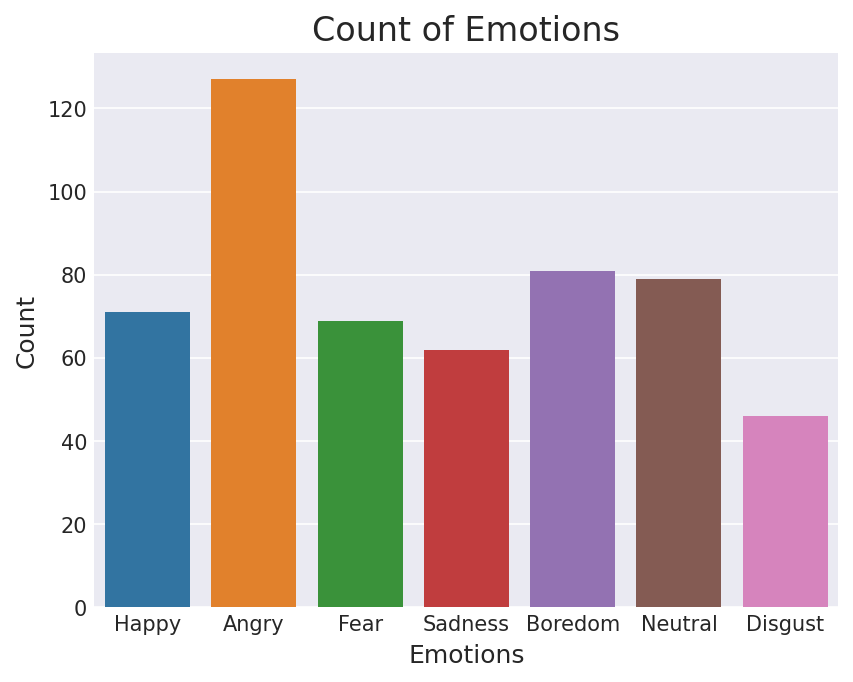

In [28]:
# plt.title('Count of Emotions', size=16)
# sns.countplot(data_path.emotion)
# plt.ylabel('Count', size=12)
# plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

from sklearn.preprocessing import LabelEncoder

# Assuming data_path is a DataFrame with an 'emotion' column (containing text labels)

# Create a label encoder
le = LabelEncoder()

# Encode the emotion labels
data_path['emotion_encoded'] = le.fit_transform(data_path['emotion'])

# Create the countplot using the encoded emotion column
plt.title('Count of Emotions', size=16)
sns.countplot(x="emotion", data=data_path)  # Use "x" for the category variable
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove top and right spines, keep bottom and left for reference
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [29]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [30]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [31]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [32]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [33]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [34]:
len(X), len(Y), data_path.path.shape

(1605, 1605, (535,))

In [35]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.111901  0.522873  0.640779  0.680774  0.638936  0.627278  0.566352   
1  0.250141  0.649256  0.724773  0.727018  0.751013  0.725293  0.615808   
2  0.110885  0.580482  0.497991  0.659925  0.665754  0.636687  0.588752   
3  0.084663  0.422190  0.431405  0.442674  0.439183  0.461294  0.441147   
4  0.178539  0.501613  0.520320  0.528365  0.531171  0.555399  0.512303   

          7         8         9  ...           146           147  \
0  0.541697  0.558623  0.587975  ...  2.585491e-09  2.403906e-09   
1  0.582014  0.601120  0.650925  ...  4.914996e-02  4.811456e-02   
2  0.530109  0.534256  0.564460  ...  3.019745e-09  2.727041e-09   
3  0.499073  0.616181  0.651516  ...  1.644588e-06  1.526782e-06   
4  0.530315  0.624426  0.653178  ...  3.867790e-03  3.798130e-03   

            148           149           150           151           152  \
0  2.275349e-09  2.180046e-09  2.109122e-09  2.058343e-09  2.021503e-09   
1  4.997509e-02  4.638703e-02  4.548307e-02  4.845985e-02  4.947733e-02   
2  2.560713e-09  2.447168e-09  2.349897e-09  2.294699e-09  2.260407e-09   
3  1.443090e-06  1.380714e-06  1.334285e-06  1.300964e-06  1.276776e-06   
4  3.859363e-03  3.520430e-03  3.752195e-03  3.627097e-03  3.567773e-03   

            153           154  labels  
0  1.997684e-09  1.982962e-09   Happy  
1  4.963606e-02  4.999541e-02   Happy  
2  1.893143e-09  8.409196e-10   Happy  
3  1.261152e-06  1.251502e-06   Happy  
4  3.679231e-03  3.916563e-03   Happy  

[5 rows x 156 columns]

In [36]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(1284, 155, 1)
(321, 155, 1)


(1605, 7)

In [37]:
lb.classes_

array(['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral',
       'Sadness'], dtype=object)

In [38]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,495 (7.60 MB)

 Trainable params: 1,989,063 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.1207 - loss: 5.8220
Epoch 1: val_accuracy improved from -inf to 0.23676, saving model to SER_best_initial_model.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.1211 - loss: 5.8172 - val_accuracy: 0.2368 - val_loss: 4.5332
Epoch 2/400
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1769 - loss: 5.0188
Epoch 2: val_accuracy did not improve from 0.23676
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1774 - loss: 5.0086 - val_accuracy: 0.2025 - val_loss: 4.3372
Epoch 3/400
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1706 - loss: 4.6766
Epoch 3: val_accuracy did not improve from 0.23676
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1713 - loss: 4.6600 - val_accuracy: 0.2025 - val_loss: 4.0805
Epoch 4/400
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1520 - loss: 4.2507
Epoch 4: val_accuracy did not improve from 0.23676
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accurac

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6223 - loss: 0.8955 
Loss of the model is -  0.779621958732605
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6223 - loss: 0.8955 
Accuracy of the model is -  65.42056202888489 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


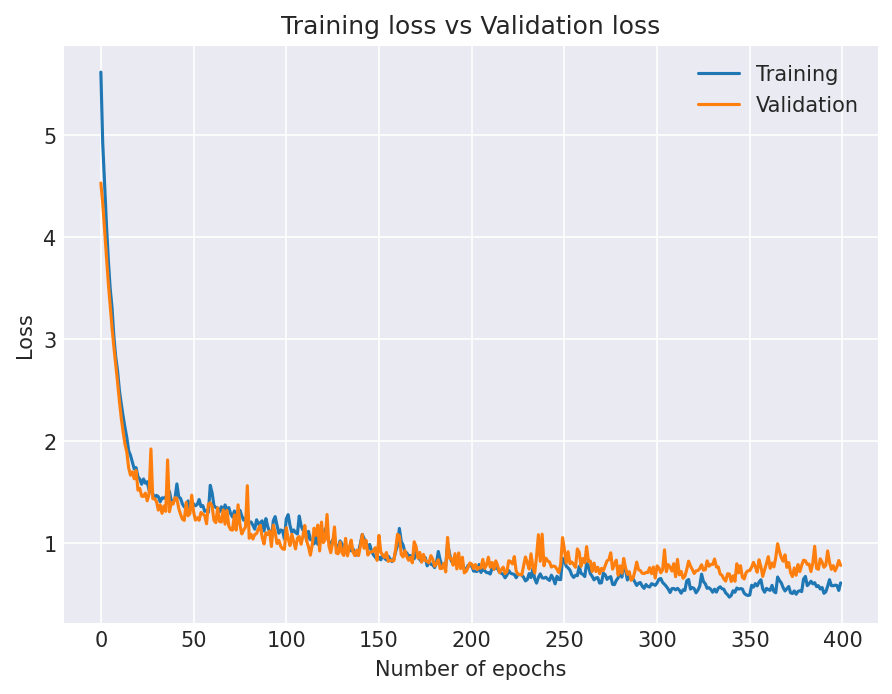

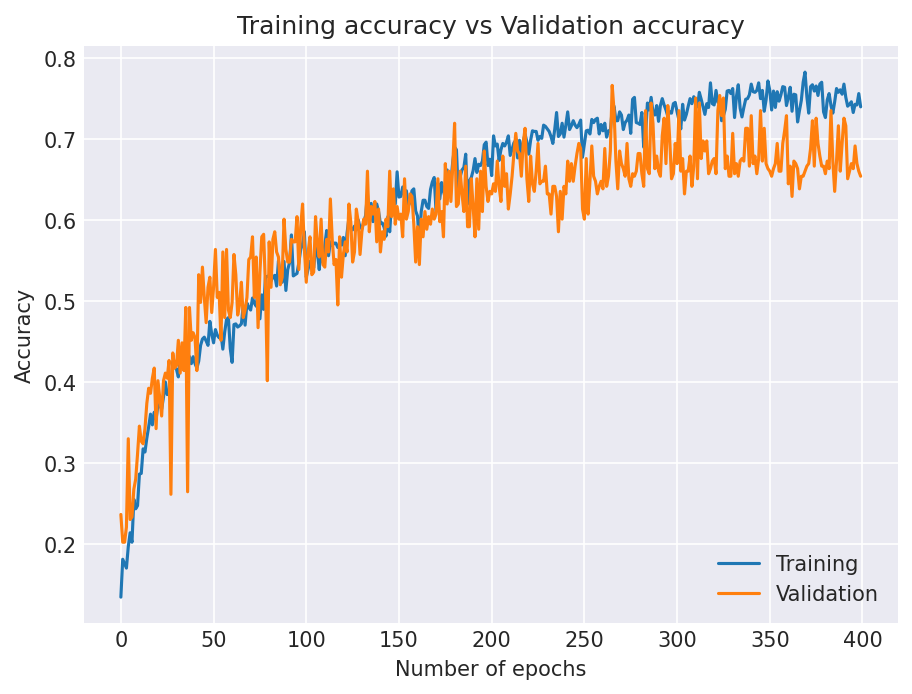

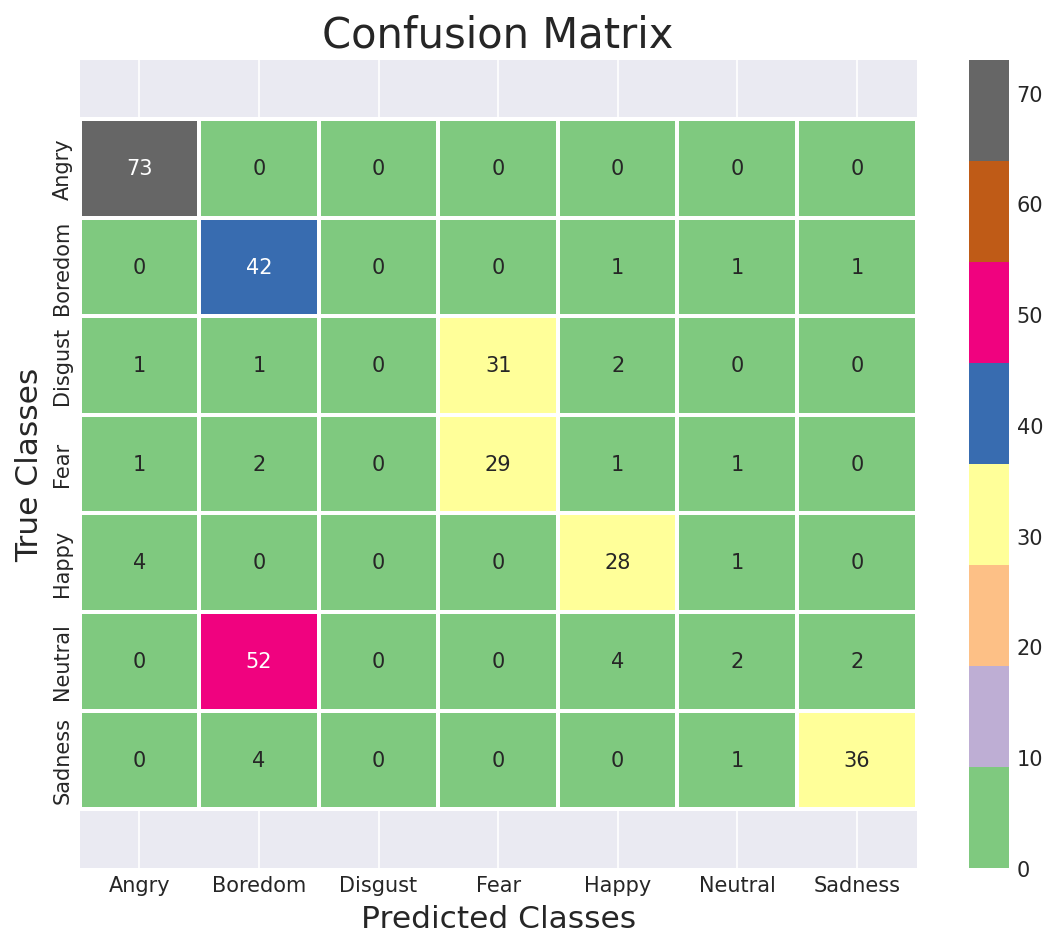

              precision    recall  f1-score   support

       Angry       0.92      1.00      0.96        73
     Boredom       0.42      0.93      0.58        45
     Disgust       0.00      0.00      0.00        35
        Fear       0.48      0.85      0.62        34
       Happy       0.78      0.85      0.81        33
     Neutral       0.33      0.03      0.06        60
         Sad       0.92      0.88      0.90        41

    accuracy                           0.65       321
   macro avg       0.55      0.65      0.56       321
weighted avg       0.58      0.65      0.57       321



In [39]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']))

In [40]:
#Accuarte class labels

In [41]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head(50)

emotion source  \
0     Happy    EMO   
1     Happy    EMO   
2     Angry    EMO   
3     Angry    EMO   
4     Angry    EMO   
5      Fear    EMO   
6     Angry    EMO   
7   Sadness    EMO   
8     Angry    EMO   
9     Angry    EMO   
10  Boredom    EMO   
11  Neutral    EMO   
12    Angry    EMO   
13  Boredom    EMO   
14  Boredom    EMO   
15    Happy    EMO   
16  Neutral    EMO   
17  Disgust    EMO   
18     Fear    EMO   
19     Fear    EMO   
20    Angry    EMO   
21    Happy    EMO   
22    Angry    EMO   
23    Angry    EMO   
24  Neutral    EMO   
25  Boredom    EMO   
26  Disgust    EMO   
27  Boredom    EMO   
28  Neutral    EMO   
29    Angry    EMO   
30     Fear    EMO   
31    Angry    EMO   
32    Angry    EMO   
33  Boredom    EMO   
34    Happy    EMO   
35  Sadness    EMO   
36    Angry    EMO   
37    Happy    EMO   
38    Happy    EMO   
39    Angry    EMO   
40  Boredom    EMO   
41  Sadness    EMO   
42  Disgust    EMO   
43    Angry    EMO   
44    Angry    EMO   
45  Disgust    EMO   
46    Angry    EMO   
47     Fear    EMO   
48  Sadness    EMO   
49    Happy    EMO   

                                                                       path  \
0   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav   
1   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav   
2   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav   
3   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav   
4   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav   
5   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a05Aa.wav   
6   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11a04Wc.wav   
7   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a05Tb.wav   
8   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a01Wc.wav   
9   /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a04Wc.wav   
10  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a04La.wav   
11  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08b02Nb.wav   
12  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12b10Wa.wav   
13  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a07Ld.wav   
14  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/10a07La.wav   
15  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11a05Fb.wav   
16  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03b01Nb.wav   
17  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12b02Ea.wav   
18  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08a01Ab.wav   
19  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/10a01Ac.wav   
20  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a02Wa.wav   
21  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a02Fd.wav   
22  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a04Wa.wav   
23  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03b01Wa.wav   
24  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Nc.wav   
25  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a05Lc.wav   
26  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a01Ea.wav   
27  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a02La.wav   
28  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15b03Nb.wav   
29  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14b02Wb.wav   
30  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a07Ac.wav   
31  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11b01Wd.wav   
32  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08a07Wc.wav   
33  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08a02La.wav   
34  /kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08b03Fe.wav   
35  /kaggle/input/berlin-database-of-

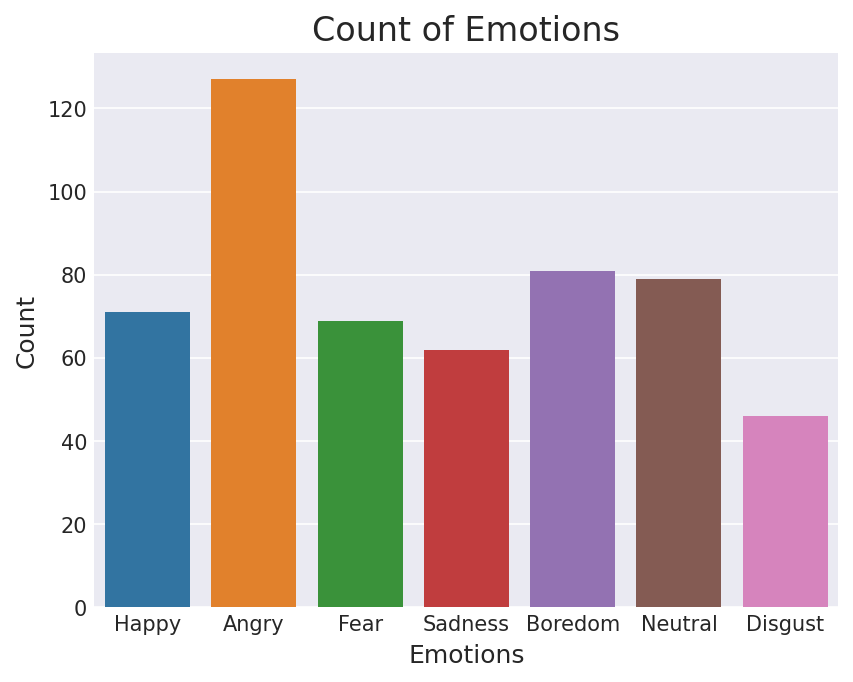

In [42]:
plt.title('Count of Emotions', size=16)
sns.countplot(x="emotion", data=data_path)  # Use "x" for the category variable
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [43]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [44]:
def noise(data):
    noise_amp = 0.015*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [45]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [46]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch2(new_data, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically

    return result

In [47]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [48]:
len(X), len(Y), data_path.path.shape

(2140, 2140, (535,))

In [49]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.111901  0.522873  0.640779  0.680774  0.638936  0.627278  0.566352   
1  0.147367  0.569820  0.606613  0.686456  0.637188  0.654840  0.576385   
2  0.110885  0.580482  0.497991  0.659925  0.665754  0.636687  0.588752   
3  0.112192  0.528675  0.484537  0.626119  0.622141  0.620934  0.541048   
4  0.084663  0.422190  0.431405  0.442674  0.439183  0.461294  0.441147   

          7         8         9  ...           146           147  \
0  0.541697  0.558623  0.587975  ...  2.585491e-09  2.403906e-09   
1  0.547317  0.537129  0.574342  ...  3.228047e-04  3.217269e-04   
2  0.530109  0.534256  0.564460  ...  3.019745e-09  2.727041e-09   
3  0.530507  0.542627  0.556969  ...  2.987474e-09  2.727393e-09   
4  0.499073  0.616181  0.651516  ...  1.644588e-06  1.526782e-06   

            148           149           150           151           152  \
0  2.275349e-09  2.180046e-09  2.109122e-09  2.058343e-09  2.021503e-09   
1  3.356249e-04  3.113124e-04  3.217010e-04  3.223626e-04  3.273257e-04   
2  2.560713e-09  2.447168e-09  2.349897e-09  2.294699e-09  2.260407e-09   
3  2.543734e-09  2.397244e-09  2.338733e-09  2.265669e-09  2.274724e-09   
4  1.443090e-06  1.380714e-06  1.334285e-06  1.300964e-06  1.276776e-06   

            153           154  labels  
0  1.997684e-09  1.982962e-09   Happy  
1  3.562669e-04  3.484364e-04   Happy  
2  1.893143e-09  8.409196e-10   Happy  
3  1.875842e-09  8.040569e-10   Happy  
4  1.261152e-06  1.251502e-06   Happy  

[5 rows x 156 columns]

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape



[[0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(1712, 155, 1)
(428, 155, 1)


(2140, 7)

In [51]:
lb.classes_

array(['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral',
       'Sadness'], dtype=object)

In [52]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,495 (7.60 MB)

 Trainable params: 1,989,063 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1503 - loss: 5.6292
Epoch 1: val_accuracy improved from -inf to 0.26402, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 401ms/step - accuracy: 0.1505 - loss: 5.6252 - val_accuracy: 0.2640 - val_loss: 4.4123
Epoch 2/400
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1871 - loss: 4.7867
Epoch 2: val_accuracy did not improve from 0.26402
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1872 - loss: 4.7809 - val_accuracy: 0.2547 - val_loss: 4.1000
Epoch 3/400
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1851 - loss: 4.2532
Epoch 3: val_accuracy improved from 0.26402 to 0.32944, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1851 - loss: 4.2442 - val_accuracy: 0.3294 - val_loss: 3.7260
Epoch 4/400
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1663 - loss: 3.7890
Epoch 4: val_accuracy did not improve from 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.4086 
Loss of the model is -  0.4001883268356323
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.4086 
Accuracy of the model is -  86.21495366096497 %
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


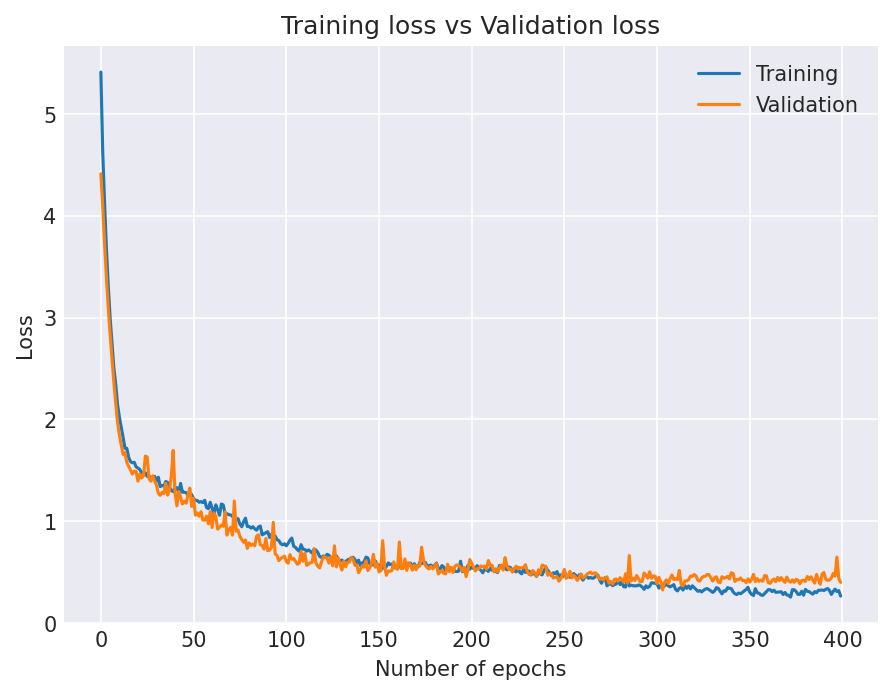

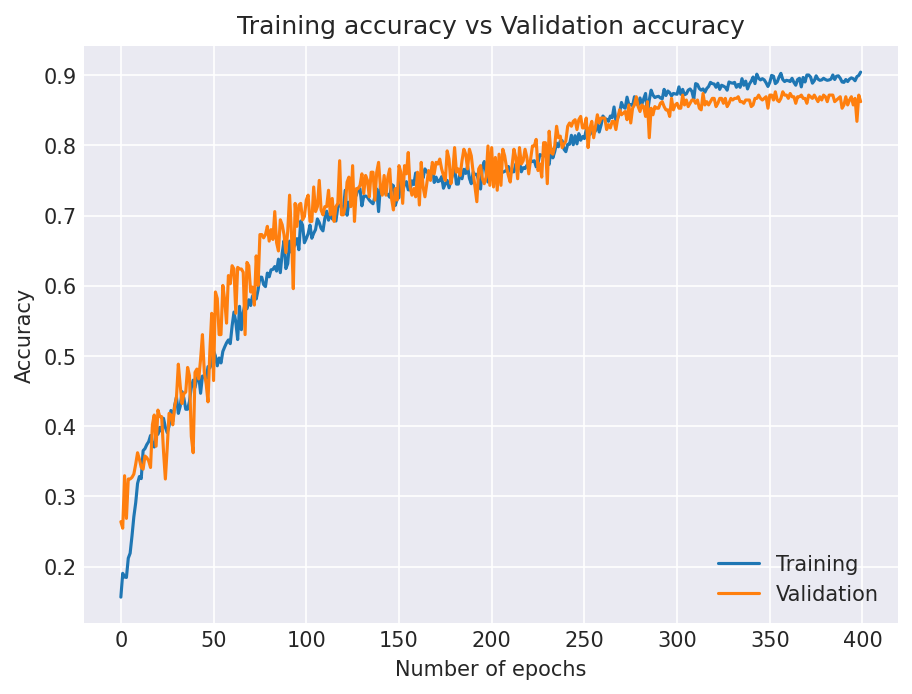

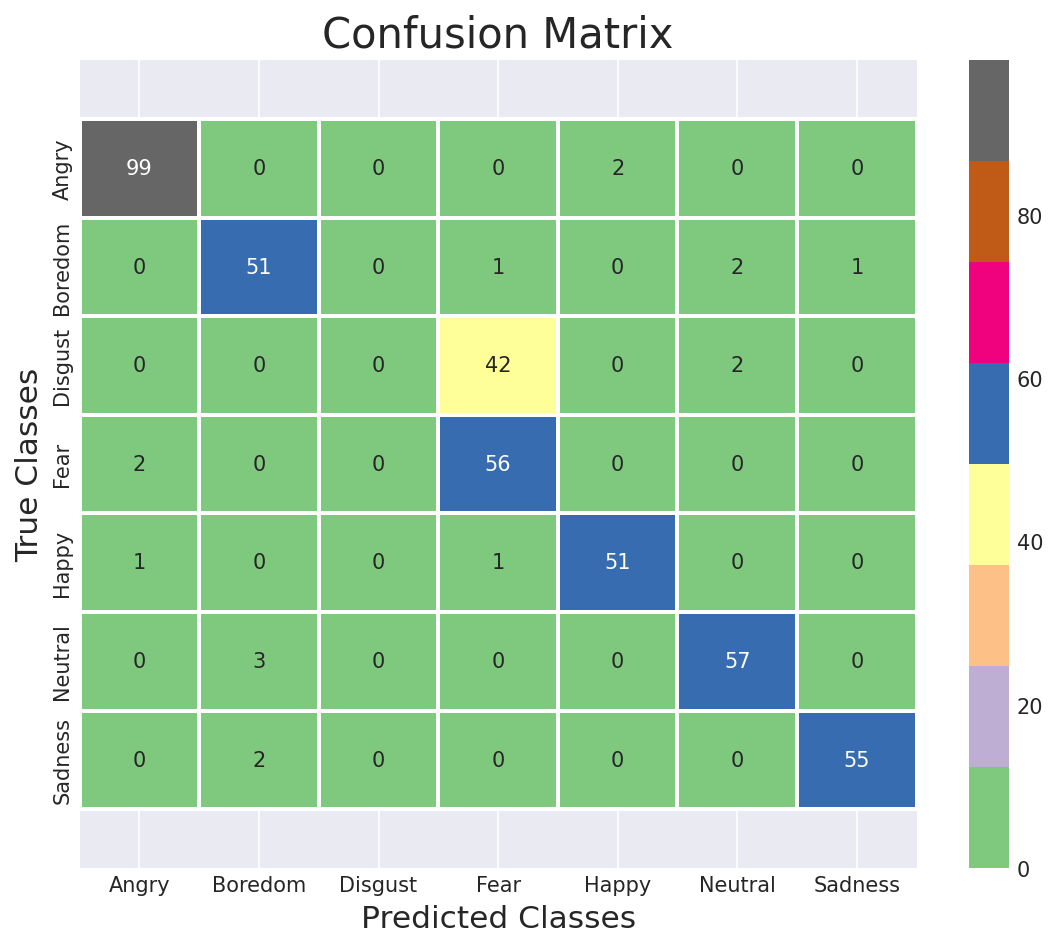

              precision    recall  f1-score   support

       Angry       0.97      0.98      0.98       101
     Boredom       0.91      0.93      0.92        55
     Disgust       0.00      0.00      0.00        44
        Fear       0.56      0.97      0.71        58
       Happy       0.96      0.96      0.96        53
     Neutral       0.93      0.95      0.94        60
     Sadness       0.98      0.96      0.97        57

    accuracy                           0.86       428
   macro avg       0.76      0.82      0.78       428
weighted avg       0.80      0.86      0.83       428



In [53]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [54]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])
model.save('german_models/model2.weights.h5')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,495 (7.60 MB)

 Trainable params: 1,989,063 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.1378 - loss: 5.9999
Epoch 1: val_accuracy improved from -inf to 0.19860, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.1382 - loss: 5.9914 - val_accuracy: 0.1986 - val_loss: 4.3948
Epoch 2/400
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1898 - loss: 4.7490
Epoch 2: val_accuracy improved from 0.19860 to 0.23598, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1906 - loss: 4.7311 - val_accuracy: 0.2360 - val_loss: 4.0704
Epoch 3/400
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1891 - loss: 4.1938
Epoch 3: val_accuracy improved from 0.23598 to 0.33178, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1909 - loss: 4.1849 - val_accuracy: 0.3318 - val_loss: 3.7170
Epoch 4/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2374 - los

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8993 - loss: 0.2788 
Loss of the model is -  0.24508816003799438
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8993 - loss: 0.2788 
Accuracy of the model is -  90.887850522995 %
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


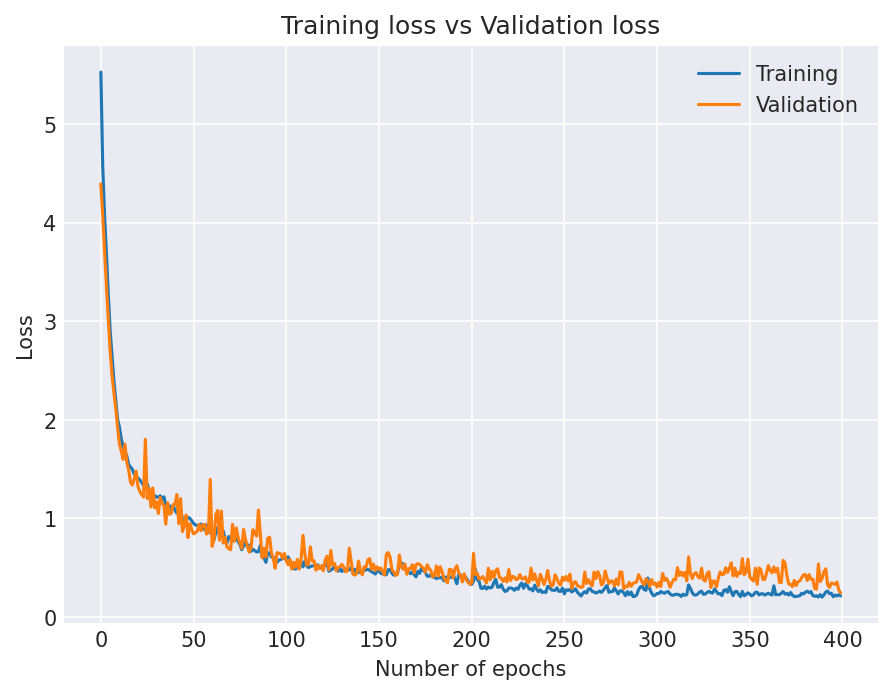

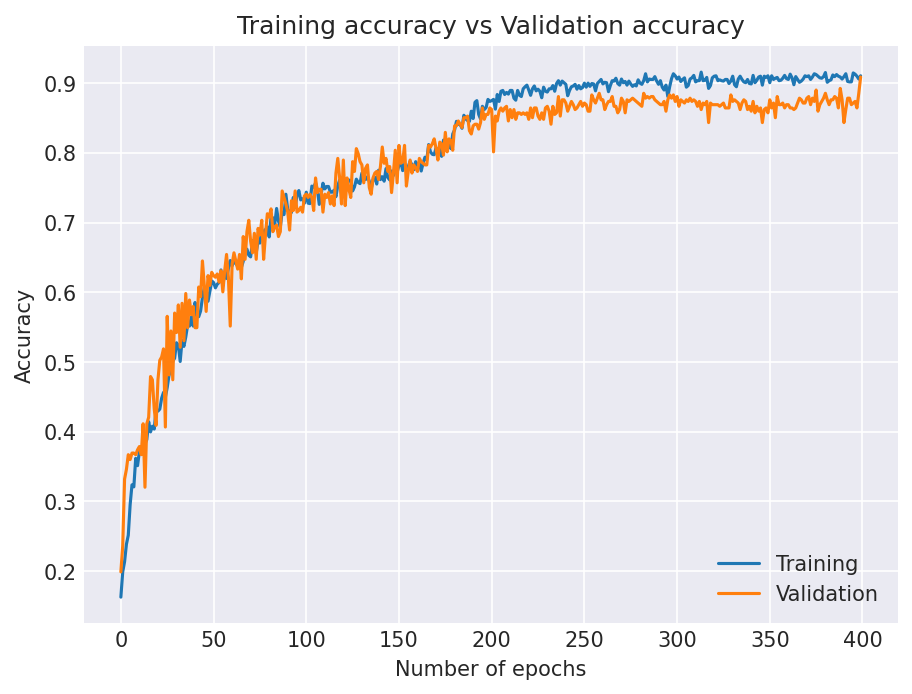

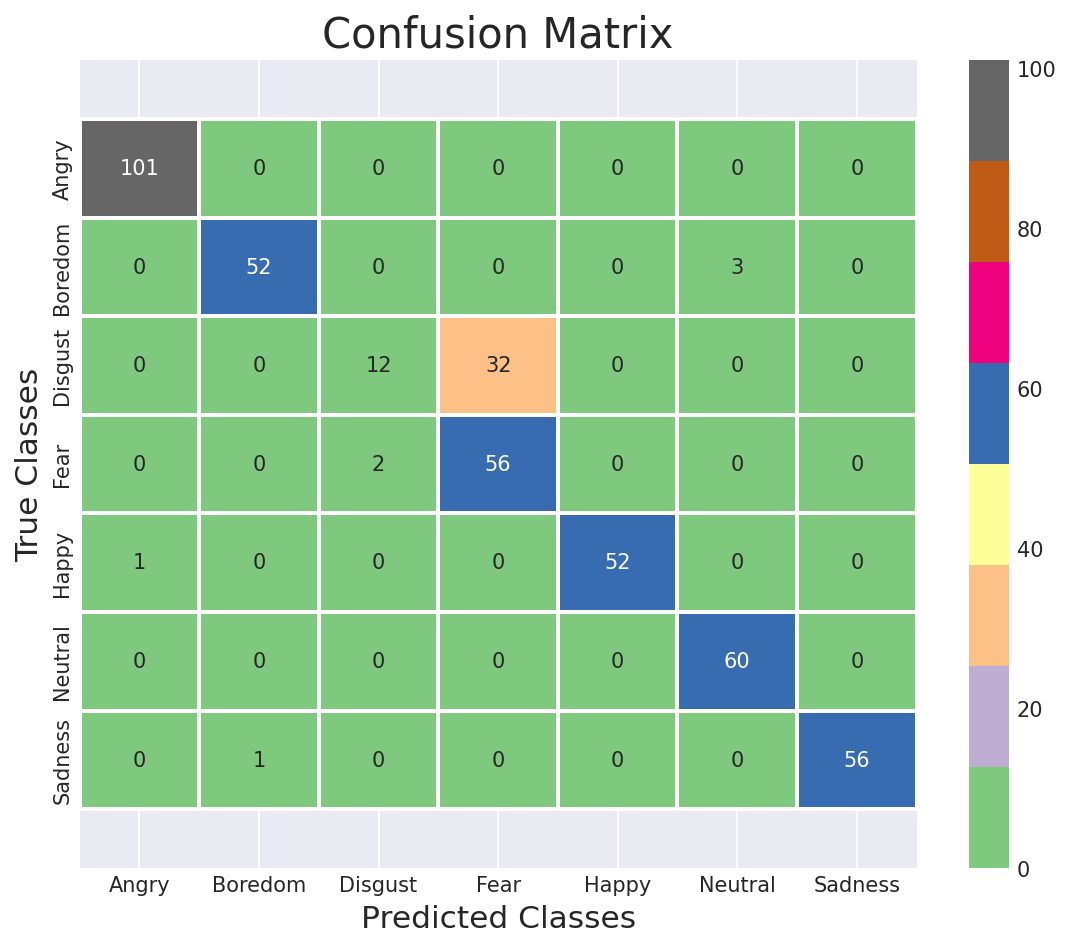

              precision    recall  f1-score   support

       Angry       0.99      1.00      1.00       101
     Boredom       0.98      0.95      0.96        55
     Disgust       0.86      0.27      0.41        44
        Fear       0.64      0.97      0.77        58
       Happy       1.00      0.98      0.99        53
     Neutral       0.95      1.00      0.98        60
     Sadness       1.00      0.98      0.99        57

    accuracy                           0.91       428
   macro avg       0.92      0.88      0.87       428
weighted avg       0.92      0.91      0.90       428



In [55]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [56]:
#ENSEMBLE TECHNIQUE

In [57]:
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(LSTM(512))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',  save_weights_only=True)
model_history2=model2.fit(x_train, y_train,batch_size=32, epochs=40, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('german_models/model2.weights.h5')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,230,535 (12.32 MB)

 Trainable params: 3,228,103 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2170 - loss: 4.0909
Epoch 1: val_accuracy improved from -inf to 0.25234, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.2176 - loss: 4.0818 - val_accuracy: 0.2523 - val_loss: 2.6467
Epoch 2/40
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3405 - loss: 2.2473
Epoch 2: val_accuracy did not improve from 0.25234
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3413 - loss: 2.2356 - val_accuracy: 0.2383 - val_loss: 1.9787
Epoch 3/40
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3995 - loss: 1.6012
Epoch 3: val_accuracy improved from 0.25234 to 0.29907, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3998 - loss: 1.5994 - val_accuracy: 0.2991 - val_loss: 1.7083
Epoch 4/40
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4373 - loss: 1.4701
Epoch 4: val_accuracy improved from 0.29907 to 0.37

In [58]:
# # Fails due to model1 is not defined


# #########################################################################
# ### Model average / sum Ensemble
# # Simple sum of all outputs / predictions and argmax across all classes
# ########
# from keras.models import load_model
# from sklearn.metrics import accuracy_score

# model1 = load_model('german_models/model1.weights.h5')
# model2 = load_model('german_models/model2.weights.h5')

# models = [model1, model2]

# preds = [model.predict(x_test) for model in models]
# preds=np.array(preds)
# summed = np.sum(preds, axis=0)

# # argmax across classes
# ensemble_prediction = np.argmax(summed, axis=1)

# prediction1 = model1.predict_classes(x_test)
# prediction2 = model2.predict_classes(x_test)

# accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
# accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
# ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

# print('Accuracy Score for model1 = ', accuracy1)
# print('Accuracy Score for model2 = ', accuracy2)
# print('Accuracy Score for average ensemble = ', ensemble_accuracy)

# ########################################
# #Weighted average ensemble
# models = [model1, model2]
# preds = [model.predict(x_test) for model in models]
# preds=np.array(preds)
# weights = [0.1, 0.9]

# #Use tensordot to sum the products of all elements over specified axes.
# weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
# weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

# weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)

# print('Accuracy Score for model1 = ', accuracy1)
# print('Accuracy Score for model2 = ', accuracy2)
# print('Accuracy Score for average ensemble = ', ensemble_accuracy)
# print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


In [59]:
# ########################################
# #Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
# models = [model1, model2]
# preds1 = [model.predict(x_test) for model in models]
# preds1=np.array(preds1)

# import pandas as pd
# df = pd.DataFrame([])

# for w1 in range(0, 5):
#     for w2 in range(0,5):
#             wts = [w1/10.,w2/10.]
#             wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
#             wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
#             weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
#             df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)

# max_acc_row = df.iloc[df['acc'].idxmax()]
# print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
#       " w2=", max_acc_row[2])

In [60]:
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(LSTM(units=512,activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history2=model3.fit(x_train, y_train,batch_size=32, epochs=40, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('german_models/model3.weights.h5')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,230,535 (12.32 MB)

 Trainable params: 3,228,103 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.1778 - loss: 4.0748
Epoch 1: val_accuracy improved from -inf to 0.23598, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - accuracy: 0.1782 - loss: 4.0659 - val_accuracy: 0.2360 - val_loss: 2.6173
Epoch 2/40
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2529 - loss: 2.3708
Epoch 2: val_accuracy improved from 0.23598 to 0.27103, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2561 - loss: 2.3537 - val_accuracy: 0.2710 - val_loss: 1.9803
Epoch 3/40
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3446 - loss: 1.7630
Epoch 3: val_accuracy improved from 0.27103 to 0.32710, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3454 - loss: 1.7584 - val_accuracy: 0.3271 - val_loss: 1.6325
Epoch 4/40
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3761 - loss: 1

In [61]:
#ENSEMBLE

In [62]:
#MODEL-1
model1 = tf.keras.Sequential()
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(7, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model1.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model1.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])
model1.save('german_models/model1-emo-db.weights.h5')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,495 (7.60 MB)

 Trainable params: 1,989,063 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.1557 - loss: 5.5119
Epoch 1: val_accuracy improved from -inf to 0.22430, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - accuracy: 0.1559 - loss: 5.5077 - val_accuracy: 0.2243 - val_loss: 4.3851
Epoch 2/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1655 - loss: 4.7717
Epoch 2: val_accuracy improved from 0.22430 to 0.24065, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1658 - loss: 4.7684 - val_accuracy: 0.2407 - val_loss: 4.0448
Epoch 3/400
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2017 - loss: 4.2246
Epoch 3: val_accuracy did not improve from 0.24065
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2018 - loss: 4.2085 - val_accuracy: 0.2360 - val_loss: 3.6682
Epoch 4/400
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2521 - loss: 3.7007
Epoch 4: val_accuracy did not improve from 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.2258 
Loss of the model is -  0.30433231592178345
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.2258 
Accuracy of the model is -  96.26168012619019 %
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


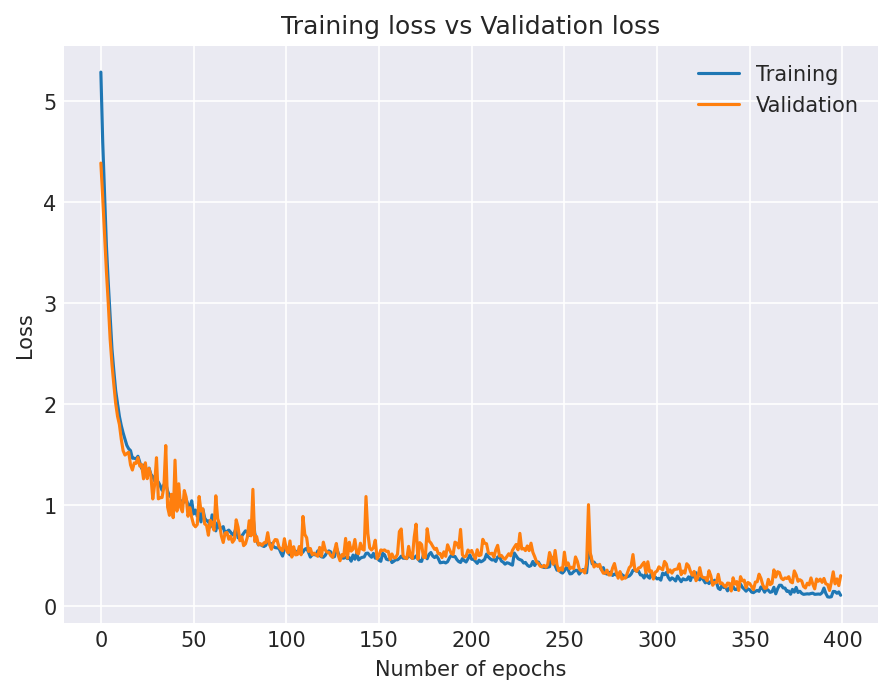

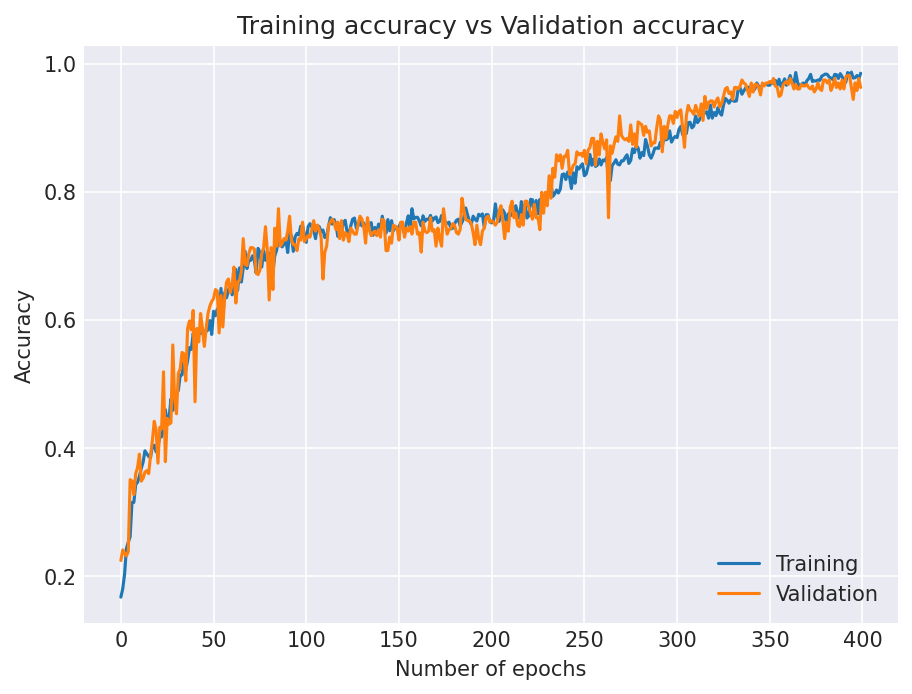

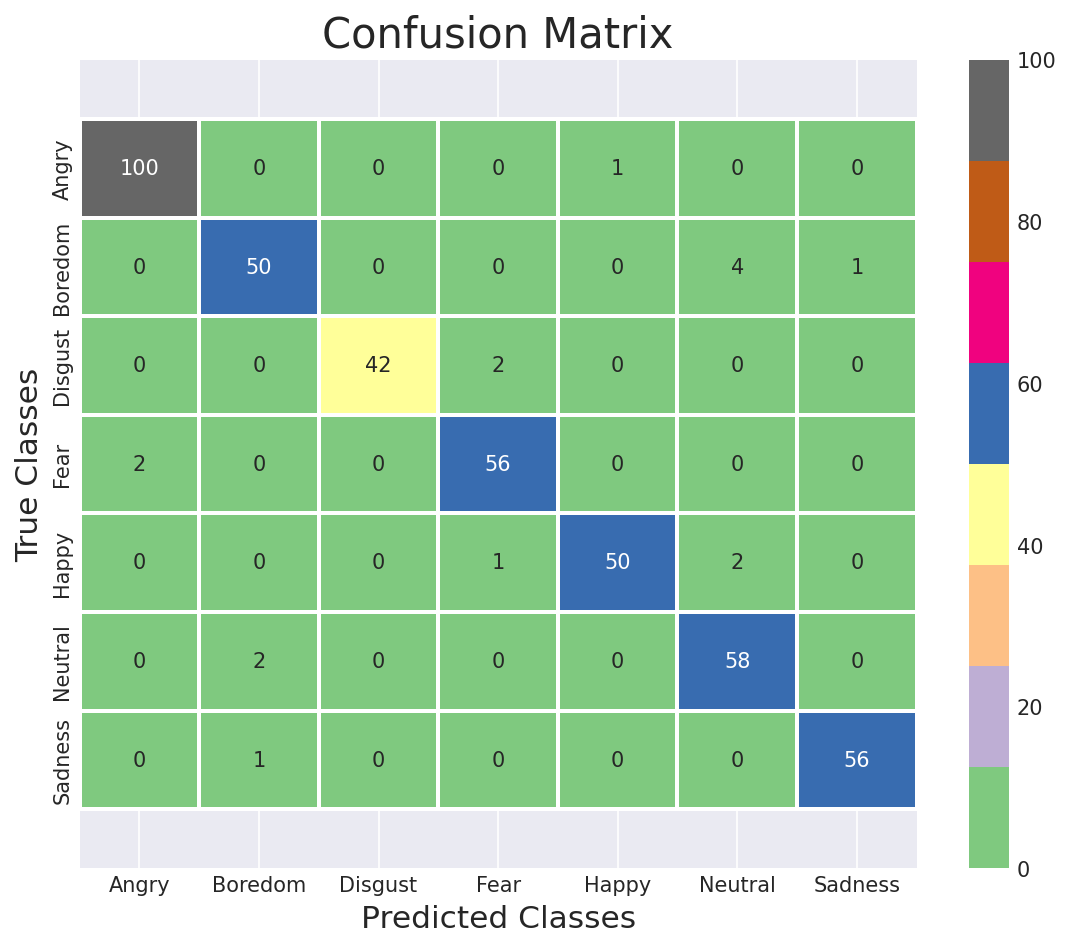

              precision    recall  f1-score   support

       Angry       0.98      0.99      0.99       101
     Boredom       0.94      0.91      0.93        55
     Disgust       1.00      0.95      0.98        44
        Fear       0.95      0.97      0.96        58
       Happy       0.98      0.94      0.96        53
     Neutral       0.91      0.97      0.94        60
     Sadness       0.98      0.98      0.98        57

    accuracy                           0.96       428
   macro avg       0.96      0.96      0.96       428
weighted avg       0.96      0.96      0.96       428



In [63]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-1.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [64]:
#MODEL-2
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.GRU(512))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model2.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('german_models/model2-emo-db.weights.h5')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_62 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,936,647 (11.20 MB)

 Trainable params: 2,934,215 (11.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1850 - loss: 4.3632
Epoch 1: val_accuracy improved from -inf to 0.33879, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.1854 - loss: 4.3581 - val_accuracy: 0.3388 - val_loss: 3.3471
Epoch 2/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3481 - loss: 2.9760
Epoch 2: val_accuracy improved from 0.33879 to 0.35748, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3478 - loss: 2.9612 - val_accuracy: 0.3575 - val_loss: 2.3408
Epoch 3/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3998 - loss: 2.0222
Epoch 3: val_accuracy did not improve from 0.35748
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4008 - loss: 2.0152 - val_accuracy: 0.2383 - val_loss: 2.0923
Epoch 4/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4624 - loss: 1.5750
Epoch 4: val_accuracy did not improve from 0.357

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.2615
Loss of the model is -  0.26460444927215576
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.2615
Accuracy of the model is -  96.26168012619019 %
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


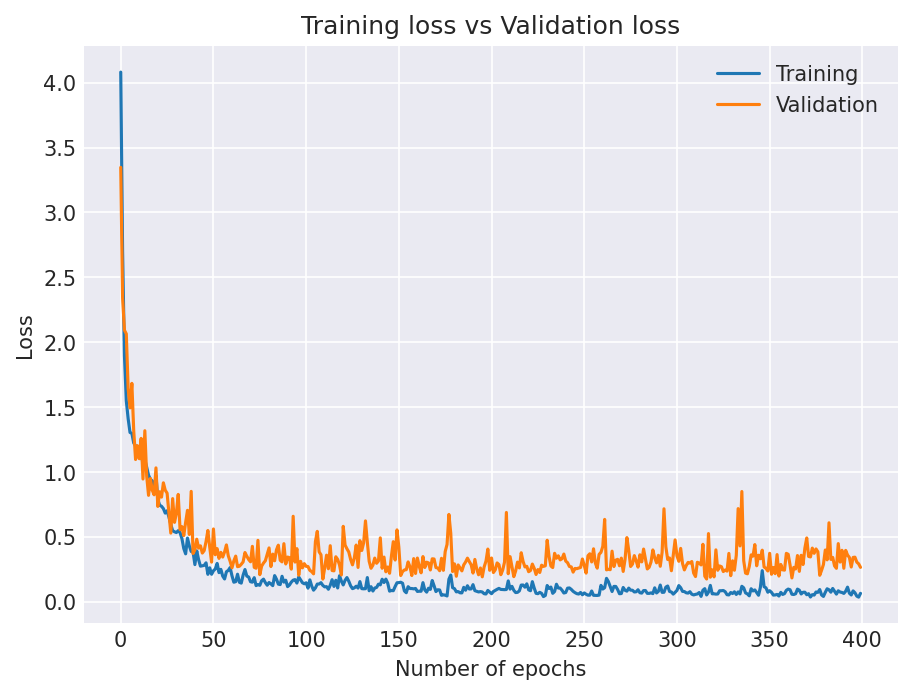

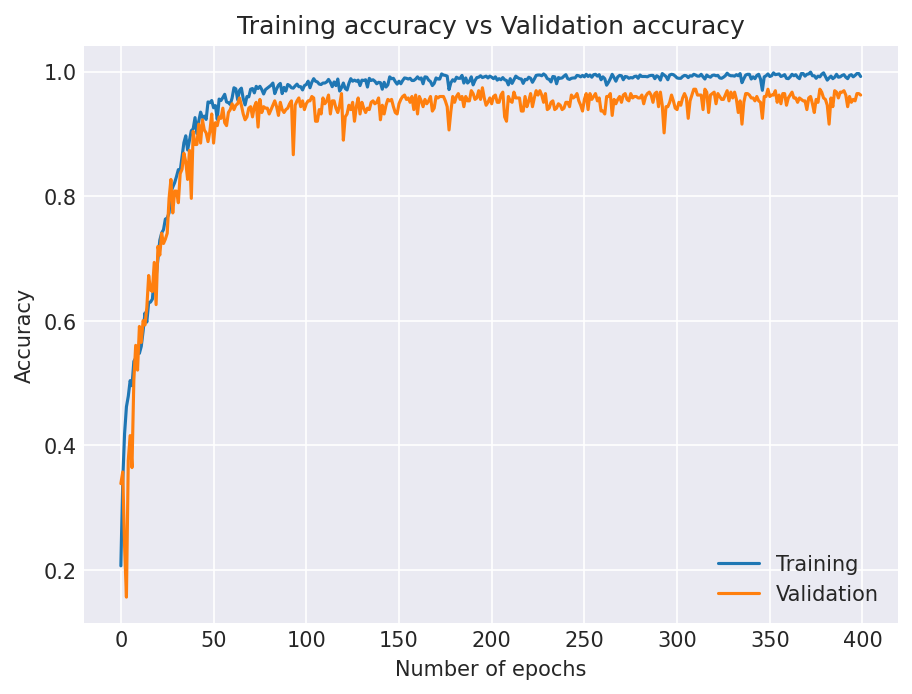

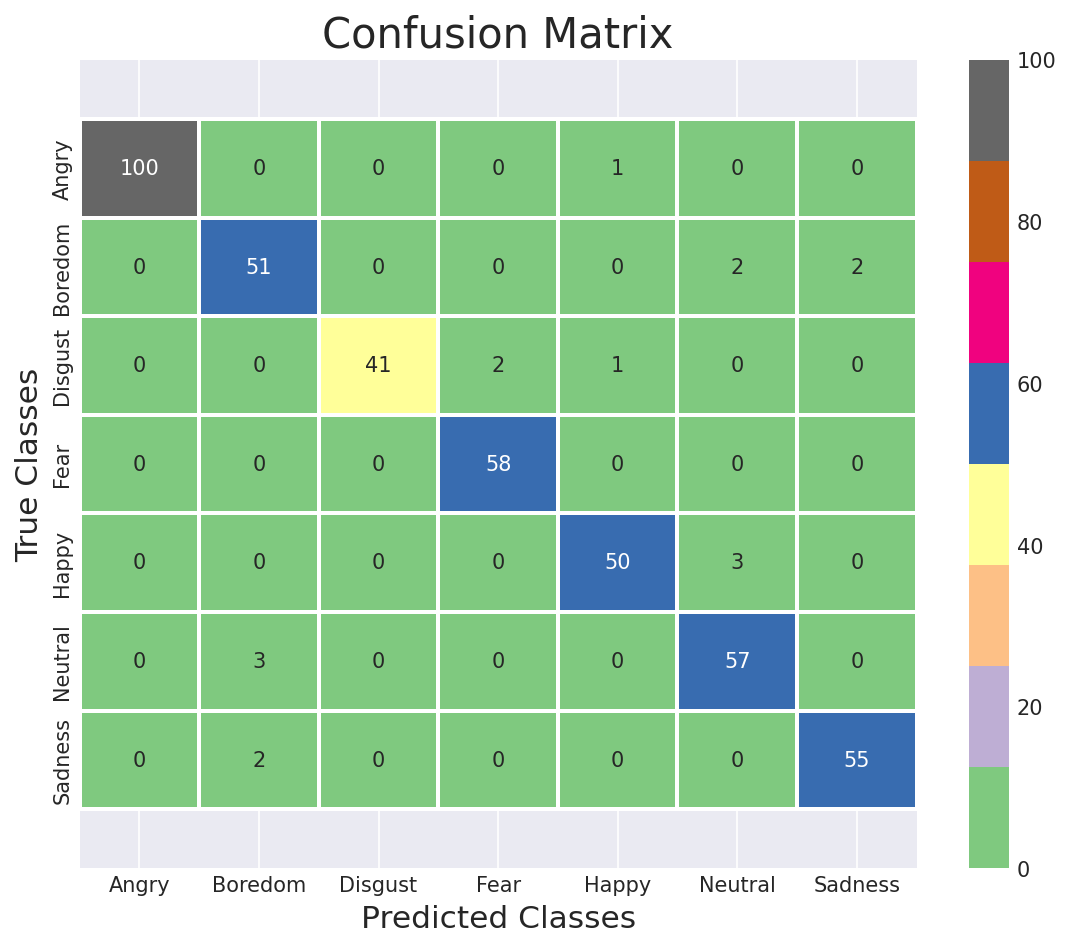

              precision    recall  f1-score   support

       Angry       1.00      0.99      1.00       101
     Boredom       0.91      0.93      0.92        55
     Disgust       1.00      0.93      0.96        44
        Fear       0.97      1.00      0.98        58
       Happy       0.96      0.94      0.95        53
     Neutral       0.92      0.95      0.93        60
     Sadness       0.96      0.96      0.96        57

    accuracy                           0.96       428
   macro avg       0.96      0.96      0.96       428
weighted avg       0.96      0.96      0.96       428



In [65]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [66]:
#MODEL-3
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.LSTM(512))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model3.fit(x_train, y_train,batch_size=32, epochs=400, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('german_models/model3-emo-db.weights.h5')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_70 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,230,535 (12.32 MB)

 Trainable params: 3,228,103 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2226 - loss: 4.1205
Epoch 1: val_accuracy improved from -inf to 0.35514, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.2247 - loss: 4.0920 - val_accuracy: 0.3551 - val_loss: 2.6308
Epoch 2/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3461 - loss: 2.1969
Epoch 2: val_accuracy improved from 0.35514 to 0.39019, saving model to SER_best_initial_model.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3468 - loss: 2.1859 - val_accuracy: 0.3902 - val_loss: 1.8516
Epoch 3/400
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3935 - loss: 1.6188
Epoch 3: val_accuracy did not improve from 0.39019
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3939 - loss: 1.6173 - val_accuracy: 0.3808 - val_loss: 1.6378
Epoch 4/400
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4213 - loss: 1.4081
Epoch 4: val_accuracy improved from 0.39019 to 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9809 - loss: 0.1678
Loss of the model is -  0.16201162338256836
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9809 - loss: 0.1678
Accuracy of the model is -  97.89719581604004 %
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


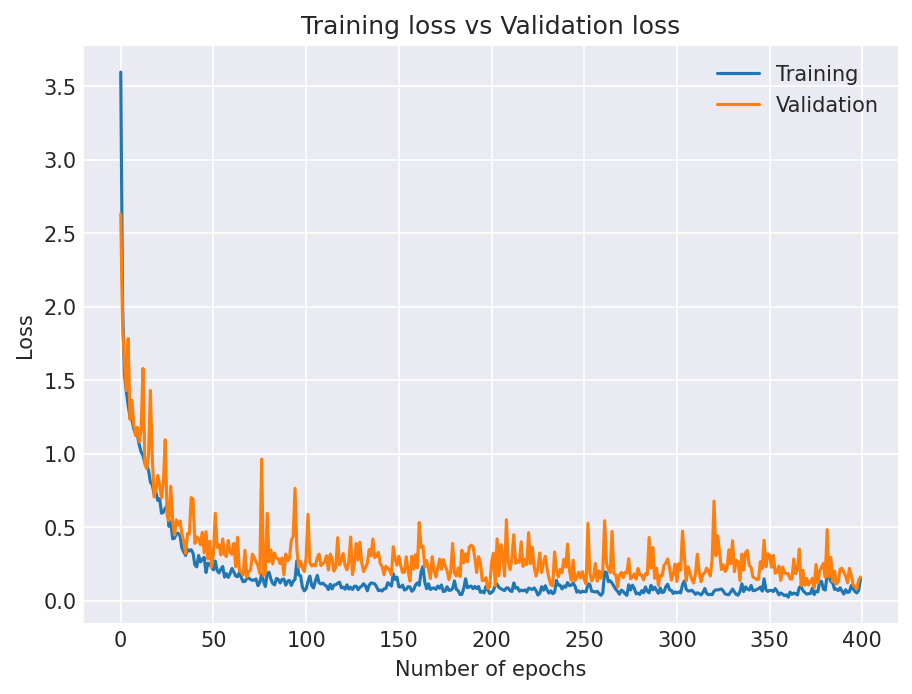

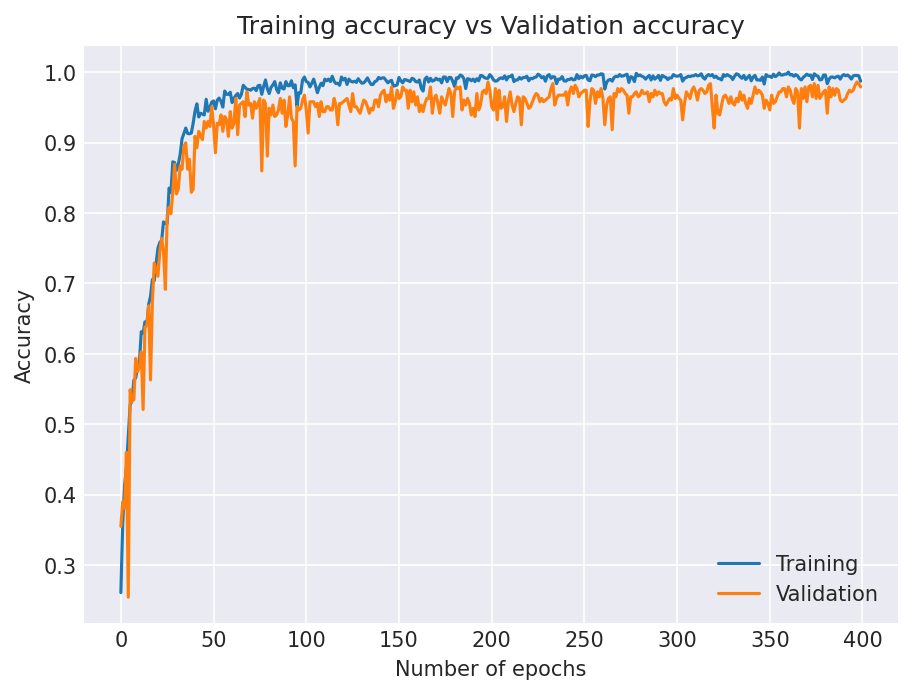

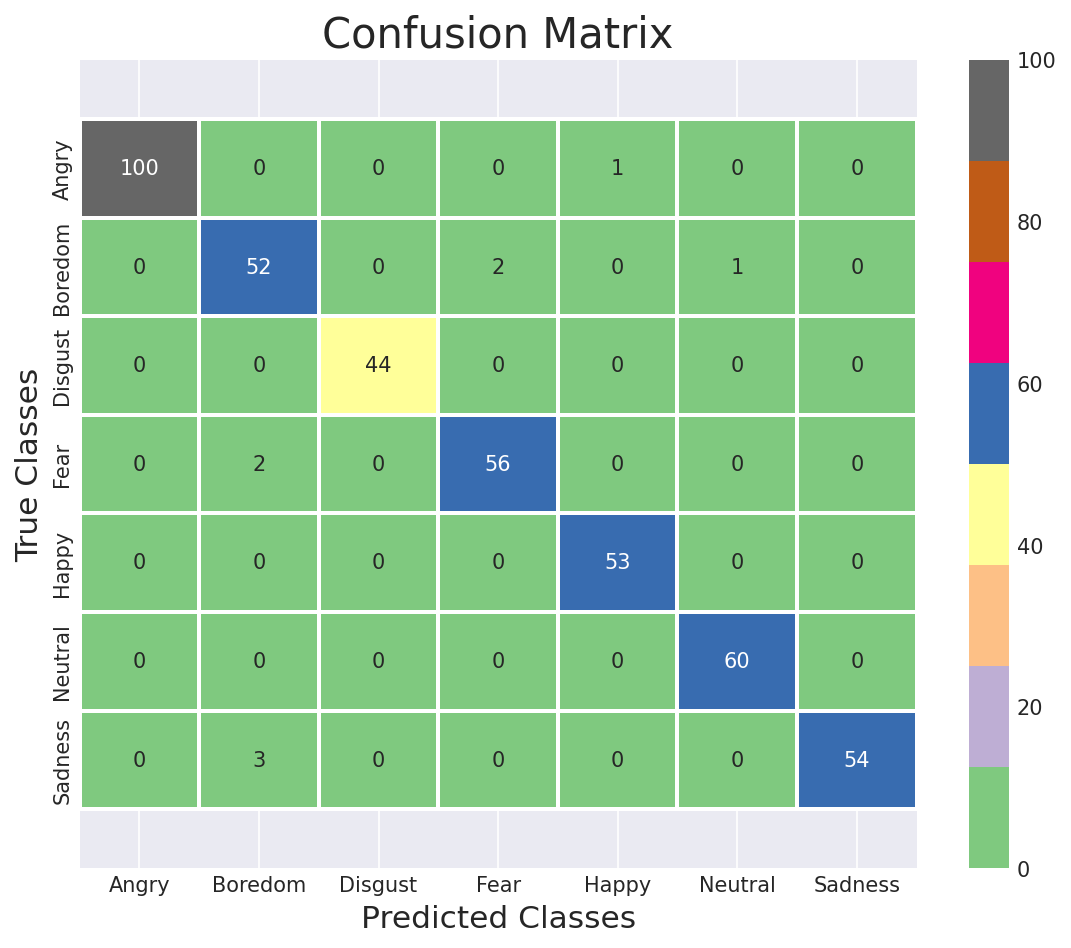

              precision    recall  f1-score   support

       Angry       1.00      0.99      1.00       101
     Boredom       0.91      0.95      0.93        55
     Disgust       1.00      1.00      1.00        44
        Fear       0.97      0.97      0.97        58
       Happy       0.98      1.00      0.99        53
     Neutral       0.98      1.00      0.99        60
     Sadness       1.00      0.95      0.97        57

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428



In [67]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-3.png')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy Score for model1 =  0.9626168224299065
Accuracy Score for model2 =  0.9626168224299065
Accuracy Score for model3 =  0.9789719626168224
Accuracy Score for average ensemble =  0.9766355140186916
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Weighted average method
Accuracy Score for model1 =  0.9626168224299065
Accuracy Score for model2 =  0.9626168224299065
Accuracy Score for model3 =  0.9789719626168224
Accuracy Score for average ensemble =  0.9766355140186916
Accuracy Score for weighted average ensemble =  0.9766355140186916
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Max accuracy of  99.06542

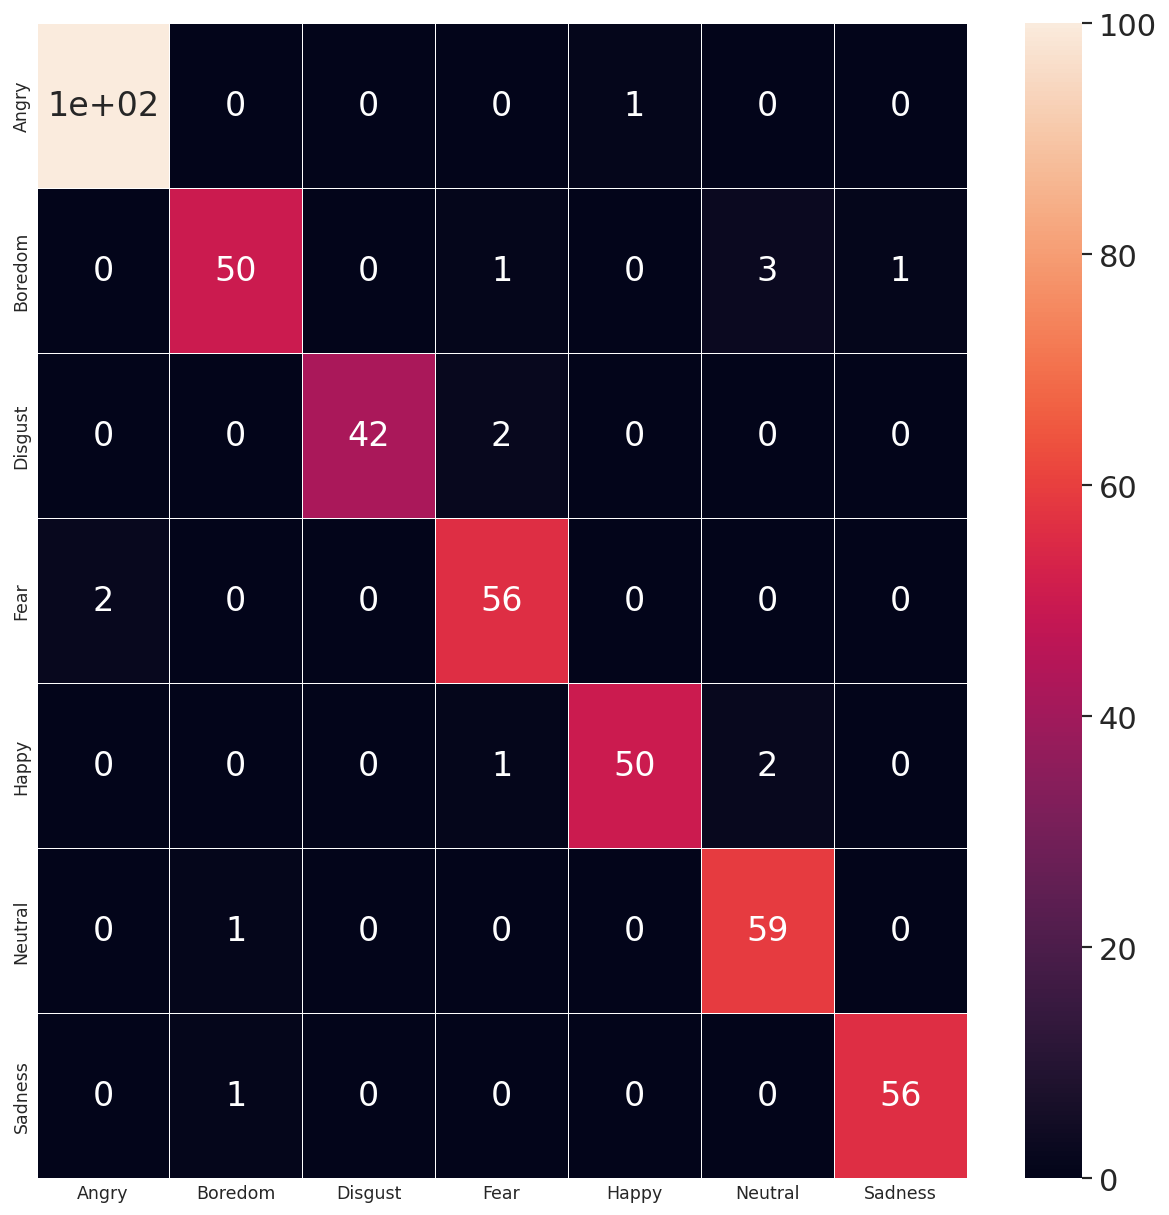

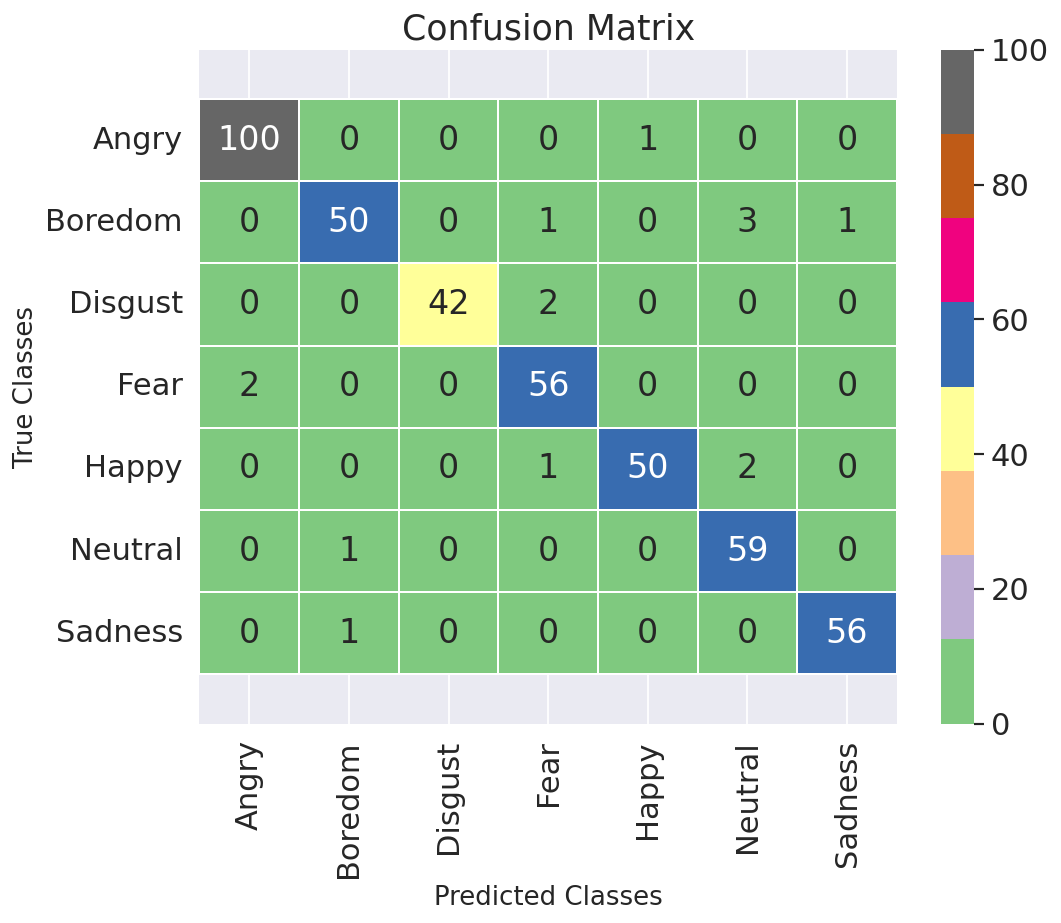

In [68]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('german_models/model1-emo-db.weights.h5')
model2 = load_model('german_models/model2-emo-db.weights.h5')
model3 = load_model('german_models/model3-emo-db.weights.h5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = np.argmax(model1.predict(x_test), axis=1)
prediction2 = np.argmax(model2.predict(x_test), axis=1)
prediction3 = np.argmax(model3.predict(x_test), axis=1)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = pd.concat([df, pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0])], ignore_index=True)

max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])




###########################################################################
### Explore metrics for the ideal weighted ensemble model.

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Weighted average method
Accuracy Score for model1 =  0.9626168224299065
Accuracy Score for model2 =  0.9626168224299065
Accuracy Score for model3 =  0.9789719626168224
Accuracy Score for average ensemble =  0.9766355140186916
Accuracy Score for weighted average ensemble =  0.9789719626168224


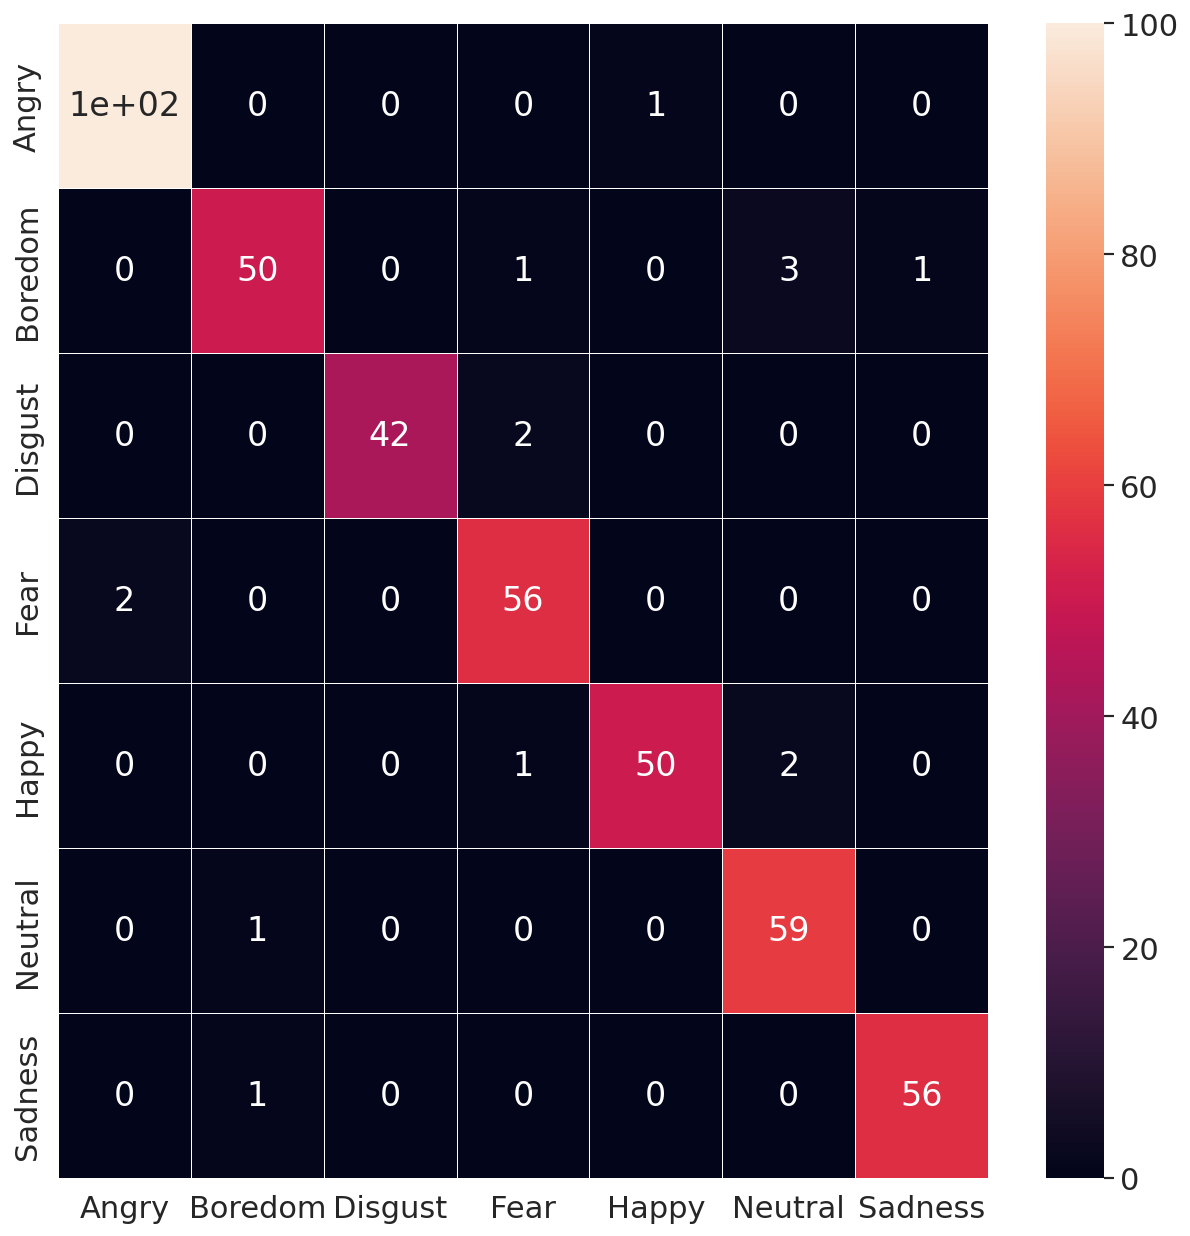

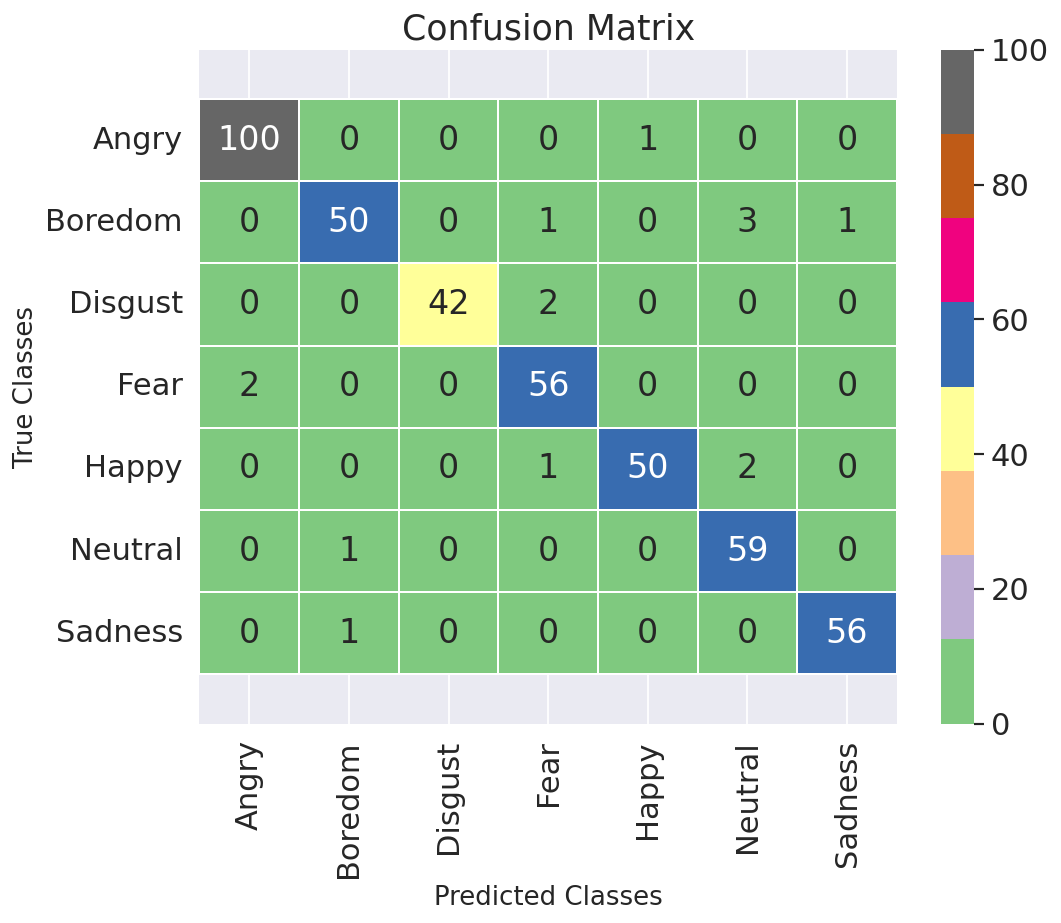

In [69]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.3, 0.1, 0.3]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('SAVEE-EMSEMBLE.png')
plt.show()

In [70]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.131.0
    Uninstalling google-api-python-client-2.131.0:
      Successfully uninstalled google-api-python-client-2.131.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.137.0 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [71]:
from googleapiclient.discovery import build
from google.oauth2 import service_account
import os 
from googleapiclient.http import MediaFileUpload


SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = '/kaggle/input/service-account/service_account.json'
PARENT_FOLDER_ID = "1-2ApPZEi4FA3fyd487CP1blLFjLac8eN"

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE,scopes=SCOPES)
    return creds

def upload_file(file_path):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)

    # Check if the path is a directory
    if os.path.isdir(file_path):
        # If it's a directory, create a folder in Google Drive
        file_metadata = {
            'name': os.path.basename(file_path), # Use the folder name
            'mimeType': 'application/vnd.google-apps.folder', # Specify folder type
            'parents': [PARENT_FOLDER_ID]
        }

        folder = service.files().create(body=file_metadata, fields='id').execute()
        folder_id = folder.get('id')

        # Upload files within the directory
        for item in os.listdir(file_path):
            item_path = os.path.join(file_path, item)
            if os.path.isfile(item_path):
                upload_file_to_folder(service, item_path, folder_id) # Call a helper function to upload individual files
    else:
        # If it's a file, upload it directly
        file_metadata = {
            'name': os.path.basename(file_path),
            'parents': [PARENT_FOLDER_ID]
        }

        media = MediaFileUpload(file_path, resumable=True) # Use MediaFileUpload for file uploads
        file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print("Folder uploaded successfully!")

def upload_file_to_folder(service, file_path, folder_id):
    """Helper function to upload a file to a specific folder."""
    file_metadata = {
        'name': os.path.basename(file_path),
        'parents': [folder_id]
    }

    media = MediaFileUpload(file_path, resumable=True)
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    
upload_file("german_models")

Folder uploaded successfully!
